In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.6

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
from jax import random
from scipy.linalg import circulant
from jax import grad, jit, vmap, value_and_grad
import optax
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp

def getStepDataSimple(angles,thres=0):
    X=np.block([[np.cos(angles)],[np.sin(angles)]]).T
    Y=(np.sin(angles)>=thres)[:,None]*2.0 - 1
    return X,Y

def loadData(dataName,N,P,seed=0,zeromean=False,labels=[0,1],All=True):
    np.random.seed(seed)

    if dataName=='MNIST':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,All=All,labels=labels)
    if dataName=='Fashion':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,All=All,home=home,labels=labels)
    if dataName=='CIFAR':
        grayscale=False
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home,labels=labels)
    if dataName=='CIFARG':
        grayscale=True
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home,labels=labels)
    if dataName=='Circulant':
        angles=np.linspace(0,2*np.pi,N)
        X,Y=getStepDataSimple(angles,thres=0)
    
    X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

    train_idx=np.random.choice(np.arange(N),P,replace=False)

    train_ID=np.ones(N)==0
    train_ID[train_idx]=True
    test_ID=np.invert(train_ID)

    x_train=X[train_ID,:]
    x_test=X[test_ID,:]

    if zeromean:
        Y=Y-np.mean(Y)
        
    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    
    return X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID

def accuracy(y_pred,y):
    return jnp.mean(y_pred == y)
def getNN(yr_test,y_class):
    pdist=pairwise_distances(yr_test, y_class, metric='euclidean')
    tp_test=jnp.argmin(pdist,axis=1)
    return y_class[tp_test,:],tp_test
def getMax(yr_test):
    tp_test=jnp.argmax(yr_test,axis=1)
    return tp_test


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.6


In [2]:
from scipy.optimize import fsolve
import scipy as sp

def getkfunc(s0,eta,P):
    def func_root(ka):
        return s0 + np.sum((ka*eta)/(ka+P*eta)) - ka
    return func_root

def getgam(eta,P,ka):
    return np.sum(P*np.square(eta)/np.square(ka+P*eta))
###

def kappa_fn(kappa, *args):
    (p, lamb, spectrum, degens) = args
    return kappa - lamb - kappa * np.sum(spectrum*degens/(p*spectrum + kappa))

def kappa_fn_derivative(kappa, *args):
    (p, lamb, spectrum, degens) = args
    return 1 - np.sum(spectrum*degens/(p*spectrum + kappa)) + kappa*np.sum(spectrum*degens/(p*spectrum + kappa)**2)

def solve_kappa(p, lamb, spectrum, degens = []):
    if len(degens) == 0:
        degens = np.ones(len(spectrum))
    
    args = (p, lamb, spectrum, degens)
    return sp.optimize.root_scalar(kappa_fn, x0 = p*np.amax(spectrum), args = args, 
                                   fprime = kappa_fn_derivative, method = 'newton').root

def gamma_fn(p, kappa, spectrum, degens = []):
    if len(degens) == 0:
        degens = np.ones(len(spectrum))
        
    return p * degens * spectrum**2 / (kappa + spectrum*p)**2
###

def runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=0,mw0=0,mh=0,mw=0,dotheory=False,s0=0,sep=False,x_test=0,y_test=0,prepend='',append=''):
    resolution=100000000#100000000
    trapz_n=10000
    chunk_size=100000

    Ls=jnp.arange(2,20)
    #pas=[0.4999,0.2,0.1]
    pas=jnp.linspace(0.4999,0.01,20)
    taus=gp.getTau(jnp.array(pas))

    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        sigma=np.squeeze(gp.getosig(tau,m=mw))
        converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)

        if dotheory:
            load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=mh0,mw0=mw0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        elif sep:
            load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getSCK_fast_and_save(x_train,x_test,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')            
        else:
            load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getSCK_fast_and_save(x_train,X,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')

        for g, L in enumerate(Ls):
        #try:
            if dotheory:
                K=np.load(load_names_te[g])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]                
            else:
                K=0
                A=np.load(load_names_tr[g])
                C=np.load(load_names_te[g])


            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)
            
            if sep:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-y_test))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(y_test))
            else:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, L:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),L))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)
                
                vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)
                
                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)
                
                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'
        VT=[]
        ERO=[]
        Kaps=[]
        Gams=[]

    #filename='gb_comp_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    filename=prepend+theory_or_not+dataName+'_P{}_N{}_mh0{}_mw0{}_mh{}_mw{}_s0{}'.format(P,N,mh0,mw0,mh,mw,s0) + append
    np.savez('./sweep_data/'+filename,P=P,N=N,mh0=mh0,mw0=mw0,mh=mh,mw=mw,s0=s0,Ls=Ls,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams,seed=seed)

    
#####

def runTrialM(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,L=3,ms=0,pas=0,dotheory=False,s0=0,sep=False,x_test=0,y_test=0,prepend='',append=''):
    resolution=10000000#100000000#100000000
    trapz_n=10000
    chunk_size=100000
    
    
    taus=gp.getTau(jnp.array(pas))

    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        for g,mw in enumerate(mws):
            sigma=np.squeeze(gp.getosig(tau,m=mw))
            converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)

            if dotheory:
                load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')
            elif sep:
                load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='train')
                load_names_te=gp.getSCK_fast_and_save(x_train,x_test,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')            
            else:
                load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='train')
                load_names_te=gp.getSCK_fast_and_save(x_train,X,converter,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')


            if dotheory:
                K=np.load(load_names_te[-1])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]                
            else:
                K=0
                A=np.load(load_names_tr[-1])
                C=np.load(load_names_te[-1])


            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)

            if sep:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-y_test))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(y_test))
            else:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, mw:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),mw))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)

                vteach=(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)

                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)

                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'
        VT=[]
        ERO=[]
        Kaps=[]
        Gams=[]

    #filename='gb_comp_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    filename=prepend+theory_or_not+dataName+'_P{}_N{}_L{}_s0{}'.format(P,N,L,s0) + append
    np.savez('./sweep_data/'+filename,P=P,N=N,L=L,mws=mws,s0=s0,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams,seed=seed)



def runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,L=3,mws=0,pas=0,dotheory=False,s0=0,sep=False,x_test=0,y_test=0,prepend='',append=''):
    resolution=10000000#100000000#100000000
    trapz_n=10000
    chunk_size=100000
    
    taus=gp.getTau(jnp.array(pas))

    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        for g,mw in enumerate(mws):
            sigma=np.squeeze(gp.getosig(tau,m=mw))
            converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
            if dotheory:
                load_names_te=gp.getSCK_flat_fast_and_save(X,X,converter,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')
            elif sep:
                load_names_tr=gp.getSCK_flat_fast_and_save(x_train,x_train,converter,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='train')
                load_names_te=gp.getSCK_flat_fast_and_save(x_train,x_test,converter,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')            
            else:
                load_names_tr=gp.getSCK_flat_fast_and_save(x_train,x_train,converter,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='train')
                load_names_te=gp.getSCK_flat_fast_and_save(x_train,X,converter,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')


            if dotheory:
                K=np.load(load_names_te[-1])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]                
            else:
                K=0
                A=np.load(load_names_tr[-1])
                C=np.load(load_names_te[-1])


            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)

            if sep:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-y_test))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(y_test))
            else:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, mw:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),mw))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)

                vteach=(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)

                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)

                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'
        VT=[]
        ERO=[]
        Kaps=[]
        Gams=[]

    #filename='gb_comp_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    filename=prepend+theory_or_not+dataName+'_P{}_N{}_L{}_s0{}'.format(P,N,L,s0) + append
    np.savez('./sweep_data/'+filename,P=P,N=N,L=L,mws=mws,s0=s0,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams,seed=seed)


########

def runTrial_last_dense_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=0,mw0=0,mh=0,mw=0,dotheory=False,s0=0,sep=False,x_test=0,y_test=0,prepend='',append=''):
    resolution=10000000#100000000#100000000
    trapz_n=10000
    chunk_size=100000

    #Ls=jnp.arange(2,20)
    L=3
    
    #mws=[16,20]#0,2,4,6]
    mws=[0,4,8,12,16,20]#0,2,4,6]
    #pas=jnp.linspace(0.4999,0.01,20)
    powermin=-3
    powermax=np.log(0.4999)/np.log(10)
    pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]
    taus=gp.getTau(jnp.array(pas))
    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(mws)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        for g,mw in enumerate(mws):
            sigma=np.squeeze(gp.getosig(tau,m=mw))
            converterA=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
            converterL=gp.getConverter_chunk_save_load(tau=gp.getTau(0.4999),resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
            if dotheory:
                load_names_te=gp.getSCK_last_layer_fast_and_save(X,X,converterA,converterL,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')
            elif sep:
                load_names_tr=gp.getSCK_last_layer_fast_and_save(x_train,x_train,converterA,converterL,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='train')
                load_names_te=gp.getSCK_last_layer_fast_and_save(x_train,x_test,converterA,converterL,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')            
            else:
                load_names_tr=gp.getSCK_last_layer_fast_and_save(x_train,x_train,converterA,converterL,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='train')
                load_names_te=gp.getSCK_last_layer_fast_and_save(x_train,X,converterA,converterL,mh0=mh0,mw0=mw0,mh=mh,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,label='test')


            if dotheory:
                K=np.load(load_names_te[-1])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]                
            else:
                K=0
                A=np.load(load_names_tr[-1])
                C=np.load(load_names_te[-1])


            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)

            if sep:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-y_test))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(y_test))
            else:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, mw:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),mw))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)

                vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)

                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)

                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converterA
        del converterL

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'
        VT=[]
        ERO=[]
        Kaps=[]
        Gams=[]

    #filename='gb_comp_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    filename=prepend+'last_dense_'+theory_or_not+dataName+'_P{}_N{}_L{}_s0{}'.format(P,N,L,s0) + append
    np.savez('./sweep_data/'+filename,P=P,N=N,L=L,mws=mws,s0=s0,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams,seed=seed)





In [3]:
Ps=np.ceil(np.power(2,np.linspace(7,12,6))).astype(int)
print(Ps)

print(2**10)

[ 128  256  512 1024 2048 4096]
1024


In [ ]:
# Two hidden layers. Same sparsity
L=3


prepend='all_'

numtrials=8

dotheory=False
zeromean=False

mws=[0,4,8,12,16,20]#0,2,4,6]
#mws=[0, 6, 12, 18, 24, 30]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]


s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']

Ps=np.ceil(np.power(2,np.linspace(7,12,6))).astype(int)
Ns=2*Ps

np.random.seed(0)
for i,P in enumerate(Ps):
    for dataName in dataNames:#dataNames:
        print(dataName)
        for j in range(numtrials):
            print(j)
            seed=j
            N=Ns[i]
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            #runTrialM(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=mh0,mw0=mw0,mh=mh,mw=mw,dotheory=False,
            #         s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))
            runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,L=L,mws=mws,pas=pas,dotheory=dotheory,
                 s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))

            

MNIST
0
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.87e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.02e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.98e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.96e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.17e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.12e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.08e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.04e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.50e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.46e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.14e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.38e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.31e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.75e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.60e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.07e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.30e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.05e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.03e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.07e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.52e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.48e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.44e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.40e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.36e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.40e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.45e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.46e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.91e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.83e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.77e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.72e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.64e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.52e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.14e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.31e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.65e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.61e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.57e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.53e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.91e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.14e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.94e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.33e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.84e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.76e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.69e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.42e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.23e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.44e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.84e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.81e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.77e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.74e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.71e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.46e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.51e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.54e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.56e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.58e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.45e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.40e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.38e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.36e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.57e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.38e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.38e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.37e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.37e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.53e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.52e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.80e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.78e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.98e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.96e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.95e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.94e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.74e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.51e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.54e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.57e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.59e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.60e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.71e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.68e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.66e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.64e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.63e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.61e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.48e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.47e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.47e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.47e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.46e-02, sigma:83.32, pa:1.00e-03, mw:20, 
3
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.66e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.64e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.85e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.83e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.82e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:2.32e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.33e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.23e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.49e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.48e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.46e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.44e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.26e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.28e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.29e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.30e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.96e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved

0th layer kernel saved
1th layer kernel saved
done
err:2.83e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.81e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.80e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.79e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.00e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.99e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.36e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.57e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.54e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.52e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.50e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.38e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.98e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.07e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.11e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.13e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.15e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.76e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.75e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.73e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.72e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.71e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.71e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.40e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.40e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.39e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.38e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.38e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.53e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.77e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.40e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.43e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.81e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.03e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.13e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.13e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.30e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.07e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.07e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.82e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.87e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.90e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.31e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.43e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.51e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.62e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.55e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.55e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded f

/mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/zebra/mypylib/chunGP.py:216: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1,figsize=(2,2))


loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.71e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.92e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.01e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.06e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.09e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.12e-02, sigma:0.52, pa:5.00e-01, mw:

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.42e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.27e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.27e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.94e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.98e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.01e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.60e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.77e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.96e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.05e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.11e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.16e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.61e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.66e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.68e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.91e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.94e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.61e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.66e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:6.35e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.39e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.65e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.82e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.91e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.98e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.77e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.66e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.90e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.93e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.96e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.57e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.62e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.65e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.20e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.27e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.12e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.16e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.20e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.23e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.26e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.60e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.64e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.71e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.77e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.81e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.21e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.32e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.60e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:83.32, pa:1.00e-03, mw:20, 
5
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.33e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.54e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.63e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.68e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.71e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.88e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.91e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.93e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.97e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.99e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.56e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.89e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.96e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.02e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.07e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.47e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.57e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.76e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.76e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.68e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.68e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:7.07e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.11e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.07e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.30e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.42e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.49e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.76e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.81e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel s

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:1.42e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.43e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.43e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.42e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.80e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.75e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.71e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.63e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.10e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.61e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.80e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.80e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.79e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.77e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.73e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.67e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.84e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.80e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.25e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.21e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.18e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.14e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.80e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.67e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.94e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.17e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.02e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.01e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.98e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.98e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.80e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.28e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.24e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.20e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.17e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.14e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.55e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:1.52e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.03e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.47e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.40e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.02e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.82e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:3.10e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.06e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.47e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.44e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.42e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.39e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.55e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.49e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.44e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.35e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.31e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:83.32, pa:1.00e-03, mw:20, 
Fashion
0
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.95e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.56e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.55e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.53e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.72e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.71e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.70e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.26e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.17e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.23e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.54e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.26e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.78e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.79e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.05e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.03e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.63e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.32e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.35e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.96e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.95e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.94e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.70e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.69e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.69e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.68e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.83e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.95e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.95e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.35e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.33e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.91e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.91e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.90e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.89e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.89e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.88e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.36e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.35e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.52e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.50e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.11e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.74e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.16e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.16e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.13e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.16e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.16e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.16e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.61e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.01e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.04e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.71e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.18e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:83.32, pa:1.00e-03, mw:20, 
3
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.43e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.61e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.69e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.74e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded fro

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.27e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.34e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.14e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.16e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.21e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.26e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.35e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.40e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.43e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.46e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.68e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.79e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded fro

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.82e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.85e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.77e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.83e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.88e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.91e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.18e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.34e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.27e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.13e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.13e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:5.19e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.82e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.92e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.96e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.99e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:6.25e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.33e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.39e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.44e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.65e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.81e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.76e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.66e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.19e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.86e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.90e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.94e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.97e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:5.31e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.38e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.44e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.48e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.52e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.04e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.52e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:83.32, pa:1.00e-03, mw:20, 
4
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.94e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.31e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.47e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded fr

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.03e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.07e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.77e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.86e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.36e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.48e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.57e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.64e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.70e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.75e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.55e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.56e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.56e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:6.67e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.74e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.78e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.81e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.92e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.11e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.86e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.89e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.91e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.71e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel sav

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:5.76e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.21e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.30e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.37e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.43e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.48e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:1.15e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.17e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.18e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.19e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.20e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.20e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.44e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.41e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.38e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.36e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.21e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.19e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.17e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.16e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.48e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.47e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.34e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.34e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.41e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.38e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.29e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.65e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.61e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.57e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
err:1.32e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.22e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.25e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.44e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.78e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.27e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.59e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.57e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.56e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.54e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.53e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.14e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.23e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.20e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.18e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.17e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.16e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.47e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.36e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.33e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.76e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded f

done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.26e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.27e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.27e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.28e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.28e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel s

0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.58e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.57e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.55e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.54e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.82e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.81e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.26e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.25e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.23e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.41e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.36e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
err:2.58e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.55e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.51e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.95e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.92e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.89e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.28e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.29e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.29e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.25e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.87e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:3.54e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.81e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.79e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.79e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.78e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.77e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.28e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.44e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.40e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.37e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.35e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:2.88e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.86e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.83e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.80e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.77e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.74e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.73e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.67e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.79e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.47e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.47e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.46e-02, sigma:83.32, pa:1.00e-03, mw:20, 
1
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.05e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.23e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded fro

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.61e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.54e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


err:1.75e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.73e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.23e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.73e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


err:1.42e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.42e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.42e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.47e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel sav

0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.96e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.96e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.80e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.79e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.94e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.96e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.61e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.17e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.30e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.30e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.29e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.87e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer ke

loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.87e-02, sigma:1.24, pa:2.60e-01, mw:

0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.40e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.53e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.53e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:5.21e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.86e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.91e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.10e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.10e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.07e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:83.32, pa:1.00e-03, mw:20, 
2
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.63e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.42e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.12e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.71e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.07e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded f

loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.83e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.07e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.18e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.25e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.29e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.33e-02, sigma:0.52, pa:5.00e-01, mw:

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.01e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.66e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.19e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.19e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.17e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.26e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.45e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.55e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.62e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.67e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.19e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.02e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.02e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.02e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.56e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.60e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.03e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:6.47e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.51e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.62e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.81e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.92e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.00e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.52e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:4.88e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.92e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.96e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.99e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.02e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer ke

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.98e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.04e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.09e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.35e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.49e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.59e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel s

0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.55e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.46e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel 

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.26e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.90e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.93e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.96e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.32e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.30e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
err:5.82e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.91e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.97e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.02e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.31e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.43e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


err:4.52e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel 

err:4.29e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.29e-02, sigma:83.32, pa:1.00e-03, mw:20, 
5
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.82e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.15e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.30e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.39e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel sa

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.82e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.85e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.88e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.91e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.93e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel s

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer ke

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.30e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.37e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.42e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.46e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.03e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel s

0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.06e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.10e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.00e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.24e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.36e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.44e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel s

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.61e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer ker

0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.54e-03, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.37e-03, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.29e-03, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.24e-03, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.21e-03, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.19e-03, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.79e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:1.01e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.04e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.05e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.05e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.06e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.18e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.15e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.13e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.11e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.10e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.32e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.72e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.70e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.68e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.67e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.02e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.01e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.84e-03, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.79e-03, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.75e-03, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.73e-03, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.05e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:9.42e-03, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.47e-03, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.51e-03, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.53e-03, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.01e-03, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.10e-03, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.11e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.09e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.08e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.32e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.28e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.25e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.65e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.64e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.98e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.97e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.95e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.94e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.87e-03, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.85e-03, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.06e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.04e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.01e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.62e-03, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.74e-03, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.81e-03, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.85e-03, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.12e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.36e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.32e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.29e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.26e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.08e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.07e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.05e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.03e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.01e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.00e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.07e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.05e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.01e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.03e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.35e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
err:9.89e-03, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.00e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.01e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved


0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.30e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.27e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.24e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.22e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.51e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.05e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.03e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.02e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.01e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.31e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.30e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.44e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.43e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.42e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.42e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.76e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.52e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.51e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.47e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:83.32, pa:1.00e-03, mw:20, 
2
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err

loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.29e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.29e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.30e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.30e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.31e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.30e-02, sigma:9.41, pa:3.65e-02, mw

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.61e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.44e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.47e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.51e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.41e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.47e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded f

# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel sav

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.87e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.47e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.52e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.82e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.89e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a 

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.47e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.45e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.89e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.46e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.40e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.41e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.54e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.52e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.60e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.64e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.18e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.24e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.10e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.12e-02, sigma:13.88, pa:1.90e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.13e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.96e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:68.70, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:4.78, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.25e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.96e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.94e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.94e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.03e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.11e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:2.69, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.72e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:13.63, pa:1.90e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:13.40, pa:1.90e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.85e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:17.72, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:17.47, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.87e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.81e-02, sigma:68.60, pa:1.39e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.84e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.85e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.84e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.84e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.84e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.24e-02, sigma:7.52, pa:5.06e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.27e-02, sigma:7.16, pa:5.06e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.30e-02, sigma:6.85, pa:5.06e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.33e-02, sigma:6.58, pa:5.06e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:39.01, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:38.86, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:38.70, pa:3.70e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:38.56, pa:3.70e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:38.41, pa:3.70e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.86e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.03e-02, sigma:2.35, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:2.12, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.14e-02, sigma:1.94, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.18e-02, sigma:1.80, pa:1.87e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.74e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:17.23, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.10e-02, sigma:17.00, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.11e-02, sigma:16.77, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.04e-02, sigma:21.68, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.05e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.01e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.00e-02, sigma:83.32, pa:1.00e-03, mw:20, 
5
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.64e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.89e-02, sigma:0.94, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.01e-02, sigma:0.75, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.08e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded fro

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:6.34, pa:5.06e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.15e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.17e-02, sigma:9.41, pa:3.65e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.19e-02, sigma:9.08, pa:3.65e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:8.78, pa:3.65e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.23e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:47.24, pa:2.67e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:47.11, pa:2.67e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:46.99, pa:2.67e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:46.86, pa:2.67e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.92e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.58e-02, sigma:3.57, pa:1.35e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.64e-02, sigma:3.21, pa:1.35e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.68e-02, sigma:2.94, pa:1.35e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.72e-02, sigma:2.73, pa:1.35e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:2.56, pa:1.35e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.96e-02, sigma:21.46, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.96e-02, sigma:21.24, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.96e-02, sigma:21.03, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.97e-02, sigma:20.83, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.91e-02, sigma:0.64, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.96e-02, sigma:0.57, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.99e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.13e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.31e-02, sigma:1.40, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.40e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:8.50, pa:3.65e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.21e-02, sigma:8.25, pa:3.65e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.06e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.08e-02, sigma:11.69, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:11.38, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.10e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded fro

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.90e-02, sigma:46.74, pa:2.67e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.90e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.90e-02, sigma:57.12, pa:1.92e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.90e-02, sigma:57.01, pa:1.92e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.90e-02, sigma:56.90, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:3.90e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.07e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.15e-02, sigma:4.64, pa:9.74e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.22e-02, sigma:4.27, pa:9.74e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.27e-02, sigma:3.98, pa:9.74e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.31e-02, sigma:3.74, pa:9.74e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.35e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:26.44, pa:7.12e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.36e-02, sigma:26.24, pa:7.12e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:26.05, pa:7.12e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:25.86, pa:7.12e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:25.67, pa:7.12e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.47e-02, sigma:1.15, pa:3.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.57e-02, sigma:1.00, pa:3.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.64e-02, sigma:0.90, pa:3.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.69e-02, sigma:0.82, pa:3.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.69e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.89e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.59e-02, sigma:11.09, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.61e-02, sigma:10.83, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:10.58, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:14.43, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:14.15, pa:1.90e-02, mw:8, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:56.79, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:56.68, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:69.00, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:68.90, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.20e-02, sigma:68.80, pa:1.39e-03, mw:12, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.07e-02, sigma:3.53, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.63e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:5.95, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:5.58, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:5.27, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:5.01, pa:7.02e-02, mw:16, 
loaded from a 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.08e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.08e-02, sigma:32.14, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.08e-02, sigma:31.96, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:31.78, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:31.61, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.09e-02, sigma:31.44, pa:5.13e-03, mw:20, 
loaded f

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.01e-02, sigma:1.97, pa:2.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.14e-02, sigma:1.68, pa:2.60e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.22e-02, sigma:1.48, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.29e-02, sigma:1.34, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.34e-02, sigma:1.24, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.52e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a 

MNIST
0
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.69e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.86e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.69e-02, sigma:1.72, pa:4.07e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kern

2th layer kernel saved
3th layer kernel saved
done
err:4.50e-02, sigma:13.15, pa:2.28e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.11e-02, sigma:11.77, pa:2.28e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.55e-02, sigma:14.94, pa:1.85e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.30e-02, sigma:13.62, pa:1.85e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th 

3th layer kernel saved
done
err:2.56e-02, sigma:5.21, pa:6.38e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.12e-02, sigma:7.80, pa:5.19e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.85e-02, sigma:6.21, pa:5.19e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.27e-02, sigma:8.91, pa:4.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th laye

done
err:2.85e-02, sigma:3.88, pa:1.45e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.11e-02, sigma:2.37, pa:1.45e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.15e-02, sigma:4.49, pa:1.18e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.17e-02, sigma:2.92, pa:1.18e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th laye

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.06e-02, sigma:2.06, pa:3.31e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.14e-02, sigma:0.92, pa:3.31e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.15e-02, sigma:2.44, pa:2.70e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.08e-02, sigma:1.19, pa

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.63e-02, sigma:19.20, pa:1.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.50e-02, sigma:18.04, pa:1.23e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.67e-02, sigma:21.74, pa:1.00e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.55e-02, sigma:20.64, pa:1.00e-02, mw:20, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.37e-02, sigma:11.57, pa:2.80e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.19e-02, sigma:10.11, pa:2.80e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.42e-02, sigma:13.15, pa:2.28e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.24e-02, sigma:11.77

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.12e-02, sigma:6.82, pa:6.38e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.08e-02, sigma:5.21, pa:6.38e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.17e-02, sigma:7.80, pa:5.19e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.05e-02, sigma:6.21, pa

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.02e-02, sigma:3.88, pa:1.45e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.28e-02, sigma:2.37, pa:1.45e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.02e-02, sigma:4.49, pa:1.18e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.18e-02, sigma:2.92, pa

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.99e-02, sigma:2.06, pa:3.31e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:5.91e-02, sigma:0.92, pa:3.31e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.80e-02, sigma:2.44, pa:2.70e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:5.67e-02, sigma:1.19, pa

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.57e-02, sigma:19.20, pa:1.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.44e-02, sigma:18.04, pa:1.23e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.61e-02, sigma:21.74, pa:1.00e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.49e-02, sigma:20.64

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.15e-02, sigma:8.65, pa:3.44e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.00e-02, sigma:11.57, pa:2.80e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.61e-02, sigma:10.11, pa:2.80e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.

err:1.16e-02, sigma:3.57, pa:9.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.32e-02, sigma:5.95, pa:7.84e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.23e-02, sigma:4.33, pa:7.84e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.71e-02, sigma:6.82, pa:6.38e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer ker

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.12e-02, sigma:2.86, pa:2.19e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:9.84e-03, sigma:1.51, pa:2.19e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.24e-02, sigma:3.34, pa:1.79e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:9.81e-03, sigma:1.90, pa:1.79e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer ker

Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.07e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.16e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.06e-02, sigma:1.72, pa:4.07e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.11e-02, sigma:11.77, pa:2.28e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.28e-02, sigma:14.94, pa:1.85e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.56e-02, sigma:13.62, pa:1.85e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.98e-02, sigma:6.21, pa:5.19e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.01e-02, sigma:8.91, pa:4.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.95e-02, sigma:7.35, pa:4.23e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.06

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.29e-02, sigma:2.92, pa:1.18e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.89e-02, sigma:5.17, pa:9.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.16e-02, sigma:3.57, pa:9.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.89

err:4.19e-02, sigma:2.44, pa:2.70e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:5.01e-02, sigma:1.19, pa:2.70e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.07e-02, sigma:2.86, pa:2.19e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.78e-02, sigma:1.51, pa:2.19e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer ker

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.34e-02, sigma:21.74, pa:1.00e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.20e-02, sigma:20.64, pa:1.00e-02, mw:20, 
3
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:5.16e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:7.79e-02, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.15e-02, sigma:13.15, pa:2.28e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.99e-02, sigma:11.77, pa:2.28e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.21e-02, sigma:14.94, pa:1.85e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.

2th layer kernel saved
3th layer kernel saved
done
err:1.45e-02, sigma:6.82, pa:6.38e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:7.31e-03, sigma:5.21, pa:6.38e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.75e-02, sigma:7.80, pa:5.19e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:8.19e-03, sigma:6.21, pa:5.19e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th laye

2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:5.97e-03, sigma:1.90, pa:1.79e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:7.87e-03, sigma:3.88, pa:1.45e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:6.00e-03, sigma:2.37, pa:1.45e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:8.91e-03, sigma:4.49, pa:1.18e-01, mw:0, 
loaded from a file
0th laye

err:nan, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:6.34e-03, sigma:1.72, pa:4.07e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:6.69e-03, sigma:0.70, pa:4.07e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:6.43e-03, sigma:2.06, pa:3.31e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel s

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.32e-02, sigma:13.62, pa:1.85e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.92e-02, sigma:16.94, pa:1.51e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.86e-02, sigma:15.70, pa:1.51e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.12e-02, sigma:19.20, pa:1.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.13e-02, sigma:8.91, pa:4.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:9.82e-03, sigma:7.35, pa:4.23e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:2.52e-02, sigma:10.16, pa:3.44e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:1.17e-02, sigma:8.65, p

2th layer kernel saved
3th layer kernel saved
done
err:3.86e-02, sigma:2.92, pa:1.18e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.51e-02, sigma:5.17, pa:9.63e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.74e-02, sigma:3.57, pa:9.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.52e-02, sigma:5.95, pa:7.84e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th laye

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.48e-02, sigma:1.19, pa:2.70e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.70e-02, sigma:2.86, pa:2.19e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.29e-02, sigma:1.51, pa:2.19e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.62e-02, sigma:3.34, pa:1.79e-01, mw:0, 
load

3th layer kernel saved
done
err:4.11e-02, sigma:21.74, pa:1.00e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.94e-02, sigma:20.64, pa:1.00e-02, mw:20, 
2
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:4.43e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:nan, sigma:0.52, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer

3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.83e-02, sigma:13.15, pa:2.28e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.62e-02, sigma:11.77, pa:2.28e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.90e-02, sigma:14.94, pa:1.85e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.69e-02, sigma:13.62, pa:1.85e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.60e-02, sigma:7.80, pa:5.19e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.58e-02, sigma:6.21, pa:5.19e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.65e-02, sigma:8.91, pa:4.23e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done
err:3.56e-02, sigma:7.35, pa

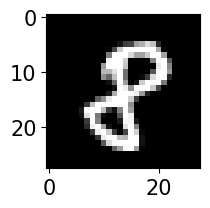

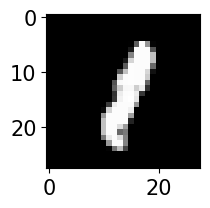

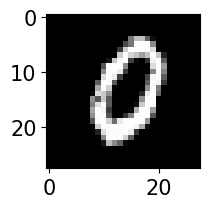

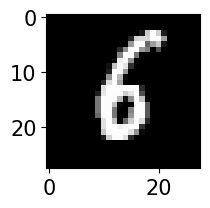

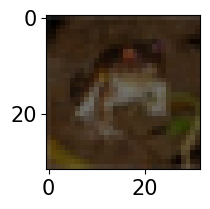

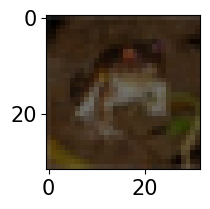

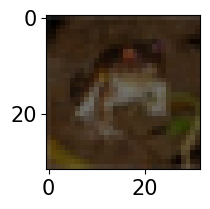

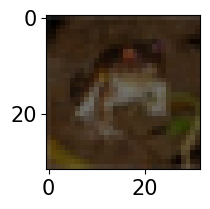

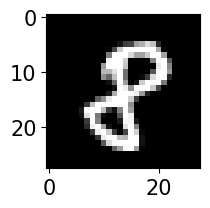

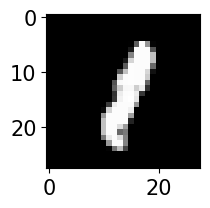

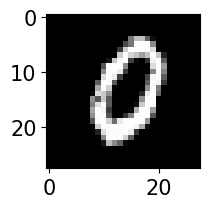

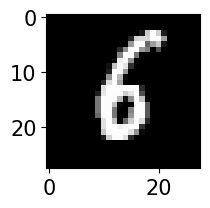

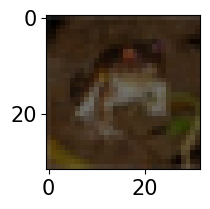

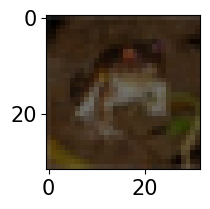

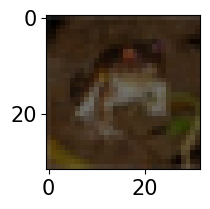

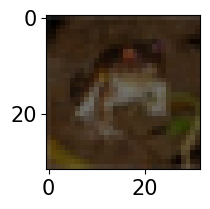

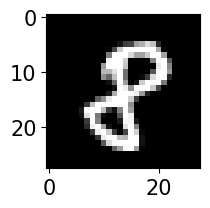

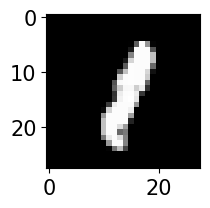

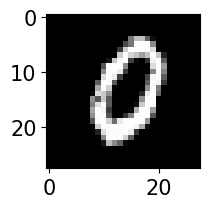

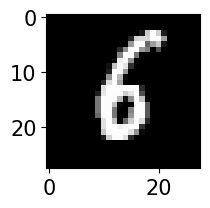

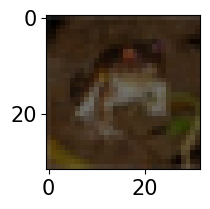

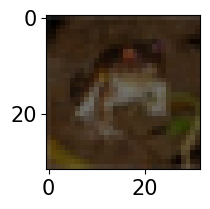

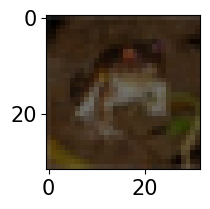

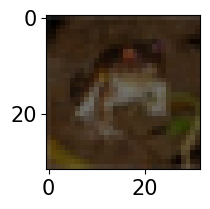

In [5]:
# 10 hidden layers. For rebuttal
L=5


prepend='rebut22_all_'

numtrials=4

dotheory=False
zeromean=False

#mws=[0,4,8,12,16,20]#0,2,4,6]
#mws=[0,50,100,150,200]
mws=[0,20]
#mws=[0, 6, 12, 18, 24, 30]
powermin=-2
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]


s0=0

dataNames=['MNIST','CIFAR']

Ps=np.ceil(np.power(2,np.linspace(7,12,3))).astype(int)
Ns=2*Ps

np.random.seed(0)
for i,P in enumerate(Ps):
    for dataName in dataNames:#dataNames:
        print(dataName)
        for j in range(numtrials):
            print(j)
            seed=j
            N=Ns[i]
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            #runTrialM(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=mh0,mw0=mw0,mh=mh,mw=mw,dotheory=False,
            #         s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))
            runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,L=L,mws=mws,pas=pas,dotheory=dotheory,
                 s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))

            

MNIST
Download complete.
Save complete.
# of training images:60000
# of test images:10000
chopped
Progress=99.00%, #chunks:1000th layer kernel saved
1th layer kernel saved
done
err:9.81e-03, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.01e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-02, sigma:1.41, pa:5.00e-01, mw:20, 
chopped
Progress=99.00%, #chunks:1000th layer kernel saved
1th layer kernel saved
done
err:9.39e-03, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel sa

1th layer kernel saved
done
err:1.47e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.43e-02, sigma:17.98, pa:1.37e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.39e-02, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.36e-02, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.33e-02, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.31e-02, sigma:17.98, pa:1.37e-02, mw:20, 
chopped
Progress=99.00%, #chunks:1000th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:21.91, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.55e-02, si

loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:2.51, pa:2.60e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:2.51, pa:2.60e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.69e-02, sigma:2.51, pa:2.60e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:3.22, pa:1.87e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:3.22, pa:1.87e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:3.22, pa:1.87e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:3.22, pa:1.87e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
do

0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:32.32, pa:5.13e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:32.32, pa:5.13e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.61e-02, sigma:32.32, pa:5.13e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:39.16, pa:3.70e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.67e-

0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:5.13, pa:9.74e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.37e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:6.40, pa:7.02e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:6.40, pa:7.02e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:6.40, pa:7.02e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:6.40, pa:7.02e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:6.40, pa:7.02e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.28e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sig

0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:57.24, pa:1.92e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:57.24, pa:1.92e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:57.24, pa:1.92e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.95e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.94e-02, sigma:69.10, pa:1.39e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.94e-02, sigma:69.10, pa:1.39e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.94e-02, sigma:69.10, pa:1.39e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.93e-02, sigma:69.10, pa:1.39e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:3.93

1th layer kernel saved
done
err:4.63e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:12.02, pa:2.63e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.71e-02, sigma:12.02, pa:2.63e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.53e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:14.72, pa:1.90e-02, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.56e-02, sigma:14.72, pa:1.90e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:4.57e-02, sigma:14.72, pa:1.9

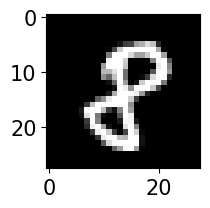

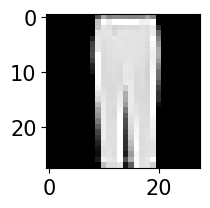

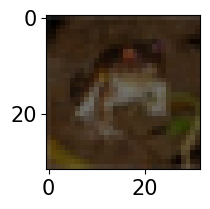

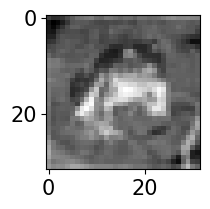

In [12]:
# Two hidden layers. Same sparsity THEORY

prepend='all_'

dotheory=True
zeromean=False

mws=[0,4,8,12,16,20]#0,2,4,6]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]
    
mws=[0,4,8,12,16,20]#0,2,4,6]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]

s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']

Ps=np.ceil(np.power(2,np.linspace(7,12,6))).astype(int)
Ns=2*Ps

np.random.seed(0)

P=2**10
N=2*P
for dataName in dataNames:#dataNames:
    print(dataName)
    #for j in range(numtrials):
    #print(j)
    seed=0
    X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
    #runTrialM(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=mh0,mw0=mw0,mh=mh,mw=mw,dotheory=dotheory,
    #         s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))
    runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mws=mws,pas=pas,dotheory=dotheory,
         s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))



In [18]:
#Circulant data
# Two hidden layers. Same sparsity THEORY

prepend='all_'

dotheory=True
zeromean=False

mws=[0,4,8,12,16,20]#0,2,4,6]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]
    
s0=1.1

dataNames=['Circulant']#dataNames:


np.random.seed(0)

P=2**10
N=2*P
for dataName in dataNames:#dataNames:
    print(dataName)
    #for j in range(numtrials):
    #print(j)
    seed=0
    X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
    #runTrialM(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=mh0,mw0=mw0,mh=mh,mw=mw,dotheory=dotheory,
             #s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))
    runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mws=mws,pas=pas,dotheory=dotheory,
         s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))



Circulant
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:7.94e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:8.80e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:9.30e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:9.66e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:9.94e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.02e-01, sigma:1.41, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:5.07e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:5.20e-02, sigma:1.91, pa:3.60e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
err:7.68e-03, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:7.99e-03, sigma:17.98, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:nan, sigma:21.91, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:2.17e-02, sigma:21.91, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:nan, sigma:21.91, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:nan, sigma:21.91, pa:9.87e-03, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:nan, sigma:21.91, pa:9.87e-03, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:nan, sigma:26.64, pa:7.1

Download complete.
Save complete.
# of training images:11552
# of test images:1902
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.21e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.34e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.40e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.43e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.45e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.46e-02, sigma:1.41, pa:5.00e-01, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:5.99e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:6.07e-02, sigma:1.91, pa:3.6

0th layer kernel saved
1th layer kernel saved
done
err:1.06e-01, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.03e-01, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.00e-01, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:9.80e-02, sigma:17.98, pa:1.37e-02, mw:20, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.29e-01, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.25e-01, sigma:21.91, pa:9.87e-03, mw:4, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.21e-01, sigma:21.91, pa:9.87e-03, mw:8, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.18e-01, sigma:21.91, pa:9.87e-03, mw:12, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
err:1.15e

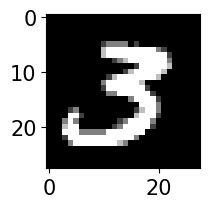

In [3]:
#OPTIMIZED FOR FLAT. kernel is now the last layer activation. runTrial_flat_M
# One dataset, TWO CLASSES
# Two hidden layers. Same sparsity THEORY

def twoClass(Y):
    ytemp=np.sum(Y*(np.arange(10)[None,:]+1),axis=1)
    newY=np.sign(ytemp-np.mean(np.unique(ytemp)))
    return newY
dataNames=['MNIST','Fashion','CIFAR','CIFARG']

np.random.seed(0)

All=False
#labels=[7,9]
#dataName=dataNames[1]
labels=[3,5]
dataName=dataNames[0]

prepend='two_classes_'

dotheory=True
zeromean=False

mws=[0,4,8,12,16,20]#0,2,4,6]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]
    

s0=0


P=2**10
N=2*P

seed=0
X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean,All=All,labels=labels)  
Y=twoClass(Y)[:,None]
y_test=twoClass(y_test)[:,None]
y_train=twoClass(y_train)[:,None]

runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mws=mws,pas=pas,dotheory=dotheory,
         s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))


    

In [10]:
def A2(thetar,taur,n=100):
    theta=thetar[None,:,None]
    xi=(jnp.pi-thetar)/2.0
    tau=taur[:,None,None]
    phi=jnp.linspace(0,xi,n).T[None,:,:]
    
    #L_term1=2*jnp.cos(phi+theta)*(jnp.sin(phi))*jnp.exp(-0.5*jnp.square(tau/jnp.sin(phi)))
    #L_term2=tau* (jnp.cos(phi+theta)) *jnp.sqrt(jnp.pi/2)*jsc.special.erf(jnp.sqrt(0.5)*tau/jnp.sin(phi))
    L_term1=-2*jnp.cos(phi+theta)*(jnp.sin(phi)/jnp.sin(theta))*jnp.exp(-0.5*jnp.square(tau/jnp.sin(phi)))
    L_term2=-tau* (jnp.cos(phi+theta)/jnp.sin(theta)) *jnp.sqrt(jnp.pi/2)*jsc.special.erf(jnp.sqrt(0.5)*tau/jnp.sin(phi))
    
    inte=jnp.trapz((L_term1+L_term2),x=phi,axis=-1)
    return jnp.squeeze(inte)

def getB(thetar,taur):
    theta=thetar[None,:]
    tau=taur[:,None]
    phi=(jnp.pi-theta)/2
    L_term1=2*jnp.sin(phi+theta)*jnp.sin(phi)*jnp.exp(-0.5*jnp.square(tau/jnp.sin(phi)))
    L_term2=tau*(jnp.sin(phi+theta)+jnp.sin(phi))*jnp.sqrt(jnp.pi/2)*jsc.special.erf(jnp.sqrt(0.5)*tau/jnp.sin(phi))
    #B = -0.5*(L_term1+L_term2)
    B = 1/(2*jnp.sin(theta)) * (L_term1+L_term2)
    return jnp.squeeze(B)

def getOptM(tau):
    I_0=jnp.squeeze(gp.I2(jnp.array([0]),jnp.array([tau]),n=10000))
    I_pih=jnp.squeeze(gp.I2(jnp.array([jnp.pi/2]),jnp.array([tau]),n=10000))
    A=A2(jnp.array([np.arccos(0.99999)]),jnp.array([tau]),n=1000)
    B=getB(jnp.array([np.arccos(0.99999)]),jnp.array([tau]))
    dIdc=A+B


    m=(2*dIdc+tau*jnp.sqrt(2*jnp.pi)-2*I_0)/(2*I_pih-tau*jnp.sqrt(2*jnp.pi))
    return m

print(getOptM(gp.getTau(0.1)))

powermin=-2
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]
print(pas)


26.935144
[0.4999     0.40688184 0.33117178 0.26954943 0.21939342 0.17857006
 0.14534287 0.11829837 0.09628617 0.07836986 0.06378728 0.05191816
 0.04225755 0.03439453 0.02799462 0.02278556 0.01854577 0.01509488
 0.01228612 0.01      ]


MNIST
0
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.50e-03, sigma:1.41, pa:5.00e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.40, pa:5.00e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kern

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.09, pa:5.00e-01, mw:700.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.00e-02, sigma:1.72, pa:4.07e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.54, pa:4.07e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer 

err:nan, sigma:0.13, pa:4.07e-01, mw:700.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.12e-02, sigma:2.06, pa:3.31e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.71, pa:3.31e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kerne

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.34e-02, sigma:2.44, pa:2.70e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.92, pa:2.70e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th l

6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.71e-02, sigma:2.86, pa:2.19e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.52e-03, sigma:1.19, pa:2.19e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved


1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.27e-02, sigma:3.34, pa:1.79e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.29e-03, sigma:1.52, pa:1.79e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.13, pa:1.79e-01, mw:73.684210

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.98e-02, sigma:3.88, pa:1.45e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.34e-03, sigma:1.92, pa:1.45e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.95e-03, sigma:1.45, pa:1.45e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer ke

err:3.64e-02, sigma:4.49, pa:1.18e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.59e-03, sigma:2.40, pa:1.18e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.30e-03, sigma:1.83, pa:1.18e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel 

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.01e-02, sigma:2.98, pa:9.63e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.38e-03, sigma:2.31, pa:9.63e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer 

6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.11e-02, sigma:3.67, pa:7.84e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.67e-03, sigma:2.88, pa:7.84e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer 

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.29e-02, sigma:4.48, pa:6.38e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.02e-02, sigma:3.57, pa:6.38e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:9.63e-03, sigma:3.06, pa:6.38

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.60e-02, sigma:5.43, pa:5.19e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.12e-02, sigma:4.41, pa:5.19e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.01e-02, sigma:3.81, pa:5.19e-02, mw:110.5263157894737, 
loaded from a fil

5th layer kernel saved
6th layer kernel saved
done
err:2.12e-02, sigma:6.53, pa:4.23e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.30e-02, sigma:5.39, pa:4.23e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.10e-02, sigma:4.70, pa:4.23e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel save

err:2.90e-02, sigma:7.79, pa:3.44e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.60e-02, sigma:6.56, pa:3.44e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.25e-02, sigma:5.77, pa:3.44e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

err:3.71e-02, sigma:9.24, pa:2.80e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.11e-02, sigma:7.91, pa:2.80e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.51e-02, sigma:7.03, pa:2.80e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.88e-02, sigma:9.49, pa:2.28e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.96e-02, sigma:8.52, pa:2.28e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.70e-02, sigma:11.30, pa:1.85e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.66e-02, sigma:10.25, pa:1.85e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th lay

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.22e-02, sigma:13.37, pa:1.51e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.51e-02, sigma:12.26, pa:1.51e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th lay

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.42e-02, sigma:15.73, pa:1.23e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.12e-02, sigma:14.57, pa:1.23e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th lay

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.48e-02, sigma:18.36, pa:1.00e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.40e-02, sigma:17.17, pa:1.00e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th lay

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.29, pa:5.00e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.24, pa:5.00e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel sa

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.39, pa:4.07e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.32, pa:4.07e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.28

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.52, pa:3.31e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.43, pa:3.31e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.37, pa:3.31e-01, mw:147.3684210526316, 
loaded from a file
0th layer ke

err:nan, sigma:0.68, pa:2.70e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.56, pa:2.70e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.49, pa:2.70e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel 

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.73, pa:2.19e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.64, pa:2.19e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel s

6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.94, pa:1.79e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.83, pa:1.79e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel s

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.21, pa:1.45e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.06, pa:1.45e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.96, pa:1.45e-01, mw:184.

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.54, pa:1.18e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.35, pa:1.18e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.22, pa:1.18e-01, mw:184.21052631578948, 
loaded from a file
0th layer 

5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.95, pa:9.63e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.72, pa:9.63e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.55, pa:9.63e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer 

err:1.48e-02, sigma:2.45, pa:7.84e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:2.17, pa:7.84e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.97, pa:7.84e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer 

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.50e-02, sigma:2.72, pa:6.38e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:2.47, pa:6.38e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer ke

6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.42e-02, sigma:3.40, pa:5.19e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.52e-02, sigma:3.10, pa:5.19e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th lay

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.40e-02, sigma:4.22, pa:4.23e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.41e-02, sigma:3.86, pa:4.23e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.48e-02, sigma:3.58, pa:4

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.40e-02, sigma:5.21, pa:3.44e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.40e-02, sigma:4.79, pa:3.44e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.40e-02, sigma:4.45, pa:3.44e-02, mw:221.0526315789474, 
loaded from a 

6th layer kernel saved
done
err:1.44e-02, sigma:6.39, pa:2.80e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.41e-02, sigma:5.90, pa:2.80e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.40e-02, sigma:5.51, pa:2.80e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel s

6th layer kernel saved
done
err:1.53e-02, sigma:7.80, pa:2.28e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.46e-02, sigma:7.24, pa:2.28e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.42e-02, sigma:6.78, pa:2.28e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel s

err:1.71e-02, sigma:9.45, pa:1.85e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.56e-02, sigma:8.81, pa:1.85e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.49e-02, sigma:8.29, pa:1.85e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved


err:2.05e-02, sigma:11.39, pa:1.51e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.78e-02, sigma:10.68, pa:1.51e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.64e-02, sigma:10.09, pa:1.51e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel sav

6th layer kernel saved
done
err:2.61e-02, sigma:13.64, pa:1.23e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.17e-02, sigma:12.87, pa:1.23e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:1.90e-02, sigma:12.21, pa:1.23e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kerne

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.35e-02, sigma:16.19, pa:1.00e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.78e-02, sigma:15.35, pa:1.00e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:2.37e-02, sigma:14.64, pa:1.00e-02, mw:221.0526315789474, 
loaded from a file
0th layer kerne

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.20, pa:5.00e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.18, pa:5.00e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.17, pa:5.00e-01, mw:221.0526315789474, 
loaded from a file
0th layer 

6th layer kernel saved
done
err:nan, sigma:0.28, pa:4.07e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.25, pa:4.07e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.23, pa:4.07e-01, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.33, pa:3.31e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.31, pa:3.31e-01, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.53e-02, sigma:1.92, pa:1.45e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.45, pa:1.45e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.33e-02, sigma:2.40, pa:1.18e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:5.59e-02, sigma:1.83, pa:1.18e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.54, pa:1.18e-01, mw:110.5263157894737, 
loaded from a file
0th

6th layer kernel saved
done
err:4.15e-02, sigma:2.98, pa:9.63e-02, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.51e-02, sigma:2.31, pa:9.63e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.95, pa:9.63e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.29e-02, sigma:2.88, pa:7.84e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.68e-02, sigma:2.45, pa:7.84e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer

5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.13e-02, sigma:3.57, pa:6.38e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.32e-02, sigma:3.06, pa:6.38e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.00e-02, sigma:4.41, pa:5.19e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.15e-02, sigma:3.81, pa:5.19e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.33e

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.91e-02, sigma:5.39, pa:4.23e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.02e-02, sigma:4.70, pa:4.23e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.14e-02, sigma:4.22, pa:4.23e-02, mw:147.3684210526316, 
loaded from a fi

6th layer kernel saved
done
err:3.86e-02, sigma:6.56, pa:3.44e-02, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.92e-02, sigma:5.77, pa:3.44e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.01e-02, sigma:5.21, pa:3.44e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel sav

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.87e-02, sigma:7.03, pa:2.80e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.92e-02, sigma:6.39, pa:2.80e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th laye

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.87e-02, sigma:8.52, pa:2.28e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.87e-02, sigma:7.80, pa:2.28e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th laye

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.93e-02, sigma:10.25, pa:1.85e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.87e-02, sigma:9.45, pa:1.85e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th lay

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.05e-02, sigma:12.26, pa:1.51e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:3.94e-02, sigma:11.39, pa:1.51e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th la

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.20e-02, sigma:14.57, pa:1.23e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.06e-02, sigma:13.64, pa:1.23e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th la

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.35e-02, sigma:17.17, pa:1.00e-02, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.21e-02, sigma:16.19, pa:1.00e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th la

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.24, pa:5.00e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.20, pa:5.00e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel s

5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.32, pa:4.07e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.28, pa:4.07e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel s

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.43, pa:3.31e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.37, pa:3.31e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.33, pa:3.31e-01, mw:184.21052631578948, 
loaded from a file
0th layer 

6th layer kernel saved
done
err:nan, sigma:0.56, pa:2.70e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.49, pa:2.70e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.44, pa:2.70e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer 

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.64, pa:2.19e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.57, pa:2.19e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel 

5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.83, pa:1.79e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.74, pa:1.79e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.06, pa:1.45e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.96, pa:1.45e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:0.

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.35, pa:1.18e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.22, pa:1.18e-01, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.12, pa:1.18e-01, mw:221.0526315789474, 
loaded from a file
0th layer 

6th layer kernel saved
done
err:nan, sigma:1.72, pa:9.63e-02, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.55, pa:9.63e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.43, pa:9.63e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.97, pa:7.84e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:1.81, pa:7.84e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel 

5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:2.47, pa:6.38e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:2.28, pa:6.38e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:7.71e-02, sigma:3.10, pa:5.19e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:2.87, pa:5.19e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sig

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.80e-02, sigma:3.86, pa:4.23e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:5.87e-02, sigma:3.58, pa:4.23e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:nan, sigma:3.35, pa:4.23e-02, mw:257.89473684210526, 
loaded from a file

6th layer kernel saved
done
err:4.52e-02, sigma:4.79, pa:3.44e-02, mw:184.21052631578948, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.70e-02, sigma:4.45, pa:3.44e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:5.12e-02, sigma:4.18, pa:3.44e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel 

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.44e-02, sigma:5.51, pa:2.80e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.56e-02, sigma:5.18, pa:2.80e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th lay

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.27e-02, sigma:6.78, pa:2.28e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.36e-02, sigma:6.40, pa:2.28e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th lay

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.16e-02, sigma:8.29, pa:1.85e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.21e-02, sigma:7.85, pa:1.85e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th lay

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.09e-02, sigma:10.09, pa:1.51e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.12e-02, sigma:9.59, pa:1.51e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th la

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.09e-02, sigma:12.21, pa:1.23e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.08e-02, sigma:11.65, pa:1.23e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th l

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.14e-02, sigma:14.64, pa:1.00e-02, mw:221.0526315789474, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
err:4.11e-02, sigma:14.01, pa:1.00e-02, mw:257.89473684210526, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
done
0th l

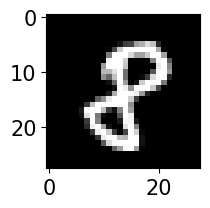

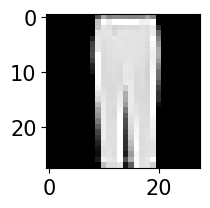

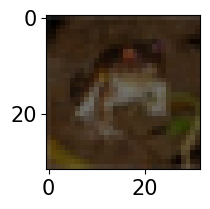

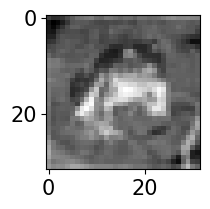

In [4]:
# Deep NN. for m vs f plane. Same sparsity

prepend='deep_all_'

numtrials=1

dotheory=False
zeromean=False

#mws=[0,4,8,12,16,20]#0,2,4,6]
mws=np.linspace(0,700,20)
powermin=-2
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]
#pas=pas[9:]

L=8#18

s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']

#Ps=np.ceil(np.power(2,np.linspace(7,12,6))).astype(int)
Ps=np.array([2**10])
Ns=2*Ps

np.random.seed(0)
for i,P in enumerate(Ps):
    for dataName in dataNames:#dataNames:
        print(dataName)
        for j in range(numtrials):
            print(j)
            seed=j
            N=Ns[i]
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            #runTrialM(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=mh0,mw0=mw0,mh=mh,mw=mw,dotheory=False,
            #         s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))
            runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,L=L,mws=mws,pas=pas,dotheory=dotheory,
                 s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))

            

In [32]:

#mws=[0,4,8,12,16,20]#0,2,4,6]
mws=[0,4,8,12,16,20]#0,2,4,6]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]

print(pas)

[0.4999     0.36044315 0.25989035 0.18738882 0.13511306 0.09742057
 0.07024321 0.05064746 0.03651837 0.02633085 0.01898534 0.013689
 0.00987019 0.0071167  0.00513136 0.00369986 0.00266772 0.0019235
 0.0013869  0.001     ]


In [33]:
L=5

mws=0
tau=gp.getTau(pas[0])

np.random.seed(0)

P=50
N=100
seed=0
zeromean=False

X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData('Circulant',N,P,seed=seed,zeromean=zeromean)  


resolution=10000000#100000000#100000000
trapz_n=10000
chunk_size=100000

#taus=gp.getTau(jnp.array(pas))

sigma=np.squeeze(gp.getosig(tau,m=mw))
converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)
load_names,load_names2=gp.getSCK_flat_fast_and_save(x_train,x_train,converter,mw=mw,sigma=sigma,L=L,input_unit_ball=False,home=home,saveKh=True,label='train')


loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
done


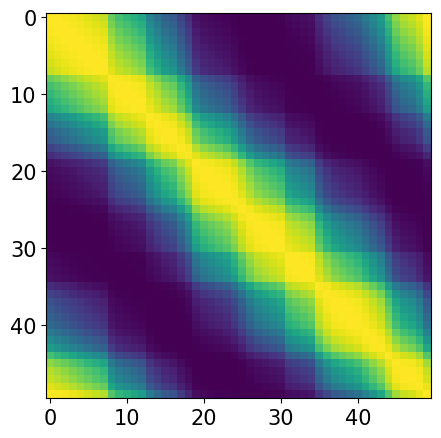

In [36]:
i=0
A=np.load(load_names[i])
C=np.load(load_names2[i])

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(A)


MNIST
0
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
chopped
Progress=90.00%, #chunks:100th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.77e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.87e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.8

0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.67e-02, sigma:7.93, pa:5.06e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:7.93, pa:5.06e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.66e-02, sig

done
0th layer kernel saved
1th layer kernel saved
done
err:1.89e-02, sigma:32.32, pa:5.13e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:32.32, pa:5.13e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.88e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:1.91, pa:3.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.16e-02, sigma:1.91, pa:3.60e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.17e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:9.78, pa:3.65e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.02e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ker

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:47.37, pa:2.67e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:47.37, pa:2.67e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:47.37, pa:2.67e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:47.37, pa:2.67e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:47.37, pa:2.67e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:3.22, pa:1.87e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:3.22, pa:1.87e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:3.22, pa:1.87e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:3.22, pa:1.87e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.06e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:14.72, pa:1.90e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.09e-02, sigma:14.72, pa:1.90e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:17.98, pa:1.37e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:69.10, pa:1.39e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:69.10, pa:1.39e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:69.10, pa:1.39e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.37e-02, sigma:69.10, pa:1.39e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:5.13, pa:9.74e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:5.13, pa:9.74e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:5.13, pa:9.74e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:5.13, pa:9.74e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:5.13, pa:9.74e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:21.91, pa:9.87e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:21.91, pa:9.87e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:21.91, pa:9.87e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.11e-02, sigma:26.64, pa:7.12e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.33e-02, sigma:83.32, pa:1.00e-03, mw:20, 
4
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.49e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.59e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.63e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.65e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file


1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:7.93, pa:5.06e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:7.93, pa:5.06e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:32.32, pa:5.13e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:32.32, pa:5.13e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.39e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

done
err:2.79e-02, sigma:1.91, pa:3.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.81e-02, sigma:1.91, pa:3.60e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.82e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.51e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.57e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.61e-02, sigma:2.51, pa:2.60e-01, mw:8, 
loaded from a fi

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.24e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.25e-02, sigma:12.02, pa:2.63e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:47.37, pa:2.67e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:47.37, pa:2.67e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:47.37, pa:2.67e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:47.37, pa:2.67e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.23e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:3.22, pa:1.87e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.22e-02, sigma:3.22, pa:1.87e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.15e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.16e-02, sigma:4.09, pa:1.35e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.17e-02, sigma:4.09, pa:1.35e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:17.98, pa:1.37e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.12e-02, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:69.10, pa:1.39e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:69.10, pa:1.39e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:69.10, pa:1.39e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:69.10, pa:1.39e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.21e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.56e-02, sigma:5.13, pa:9.74e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.57e-02, sigma:5.13, pa:9.74e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.50e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.50e-02, sigma:6.40, pa:7.02e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.51e-02, sigma:6.40, pa:7.02e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:26.64, pa:7.12e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:26.64, pa:7.12e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:26.64, pa:7.12e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.41e-02, sigma:26.64, pa:7.12e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1t

0th layer kernel saved
1th layer kernel saved
done
err:2.34e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.38e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.40e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.43e-02, sigma:1.41, pa:5.00e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.13e-02, si

done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:7.93, pa:5.06e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:9.78, pa:3.65e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-0

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:39.16, pa:3.70e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:39.16, pa:3.70e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.42e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.45e-02, sigma:2.51, pa:2.60e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.46e-02, sigma:2.51, pa:2.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.48e-02, sigma:2.51, pa:2.60e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.49e-02, sigma:2.51, pa:2.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:12.02, pa:2.63e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.20e-02, sigma:12.02, pa:2.63e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:14.72, pa:1.90e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:47.37, pa:2.67e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.19e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:57.24, pa:1.92e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:57.24, pa:1.92e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.18e-02, sigma:57.24, pa:1.92e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.14e-02, sigma:4.09, pa:1.35e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.17e-02, sigma:4.09, pa:1.35e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.20e-02, sigma:4.09, pa:1.35e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.23e-02, sigma:4.09, pa:1.35e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.24e-02, sigma:4.09, pa:1.35e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.71e-02, sigma:17.98, pa:1.37e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.65e-02, sigma:21.91, pa:9.87e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.50e-02, sigma:69.10, pa:1.39e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.48e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1t

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.69e-02, sigma:6.40, pa:7.02e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.71e-02, sigma:6.40, pa:7.02e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:6.40, pa:7.02e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.74e-02, sigma:6.40, pa:7.02e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.76e-02, sigma:6.40, pa:7.02e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:26.64, pa:7.12e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:26.64, pa:7.12e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.38e-02, sigma:26.64, pa:7.12e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.35e-02, sigma:32.32, pa:5.13e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.37e-02, sigma:1.41, pa:5.00e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.89e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:1.91, pa:3.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:1.91, pa:3.60e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.09e-02, sigma:1.91, pa:3.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:9.78, pa:3.65e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:9.78, pa:3.65e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.41e-02, sigma:9.78, pa:3.65e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.42e-02, sigma:9.78, pa:3.65e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.43e-02, sigma:9.78, pa:3.65e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:39.16, pa:3.70e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:39.16, pa:3.70e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.22e-02, sigma:39.16, pa:3.70e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.19e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.19e-02, sigma:47.37, pa:2.67e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.05e-02, sigma:2.51, pa:2.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.64e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.73e-02, sigma:3.22, pa:1.87e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.78e-02, sigma:3.22, pa:1.87e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.82e-02, sigma:3.22, pa:1.87e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.13e-02, sigma:14.72, pa:1.90e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.14e-02, sigma:14.72, pa:1.90e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.15e-02, sigma:14.72, pa:1.90e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.16e-02, sigma:14.72, pa:1.90e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.16e-02, sigma:14.72, pa:1.90e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:57.24, pa:1.92e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.87e-02, sigma:57.24, pa:1.92e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.88e-02, sigma:57.24, pa:1.92e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.85e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.86e-02, sigma:69.10, pa:1.39e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.26e-02, sigma:4.09, pa:1.35e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:5.13, pa:9.74e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:5.13, pa:9.74e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.10e-02, sigma:5.13, pa:9.74e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:21.91, pa:9.87e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:21.91, pa:9.87e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:21.91, pa:9.87e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.68e-02, sigma:21.91, pa:9.87e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.68e-02, sigma:21.91, pa:9.87e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.51e-02, sigma:83.32, pa:1.00e-03, mw:20, 
CIFARG
0
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.37e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.59e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.60e-02, sigma:6.40, pa:7.02e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.40e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.42e-02, sigma:7.93, pa:5.06e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.44e-02, sigma:7.93, pa:5.06e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.46e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.04e-02, sigma:32.32, pa:5.13e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:32.32, pa:5.13e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:32.32, pa:5.13e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.16e-02, sigma:1.91, pa:3.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.19e-02, sigma:1.91, pa:3.60e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.22e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.68e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.80e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.17e-02, sigma:9.78, pa:3.65e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.06e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.08e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ker

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:47.37, pa:2.67e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.79e-02, sigma:47.37, pa:2.67e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:47.37, pa:2.67e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:47.37, pa:2.67e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.80e-02, sigma:47.37, pa:2.67e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.57e-02, sigma:3.22, pa:1.87e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.60e-02, sigma:3.22, pa:1.87e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.62e-02, sigma:3.22, pa:1.87e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.30e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.35e-02, sigma:4.09, pa:1.35e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.95e-02, sigma:14.72, pa:1.90e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.88e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.89e-02, sigma:17.98, pa:1.37e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.89e-02, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.90e-02, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:69.10, pa:1.39e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:69.10, pa:1.39e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:69.10, pa:1.39e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:69.10, pa:1.39e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.70e-02, sigma:69.10, pa:1.39e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.92e-02, sigma:5.13, pa:9.74e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.94e-02, sigma:5.13, pa:9.74e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.96e-02, sigma:5.13, pa:9.74e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.72e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.76e-02, sigma:6.40, pa:7.02e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.40e-02, sigma:21.91, pa:9.87e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.33e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.33e-02, sigma:26.64, pa:7.12e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.34e-02, sigma:26.64, pa:7.12e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.34e-02, sigma:26.64, pa:7.12e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.76e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.88e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.95e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.99e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:7.04e-02, sigma:1.41, pa:5.00e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.47e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.48e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.50e-02, sigma:7.93, pa:5.06e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.32e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.34e-02, sigma:9.78, pa:3.65e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.99e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:39.16, pa:3.70e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.00e-02, sigma:39.16, pa:3.70e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel save

/mnt/homes/@LH-CORNELL.EDU/61/cc2465-1000003/projects/zebra/mypylib/chunGP.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1,figsize=(2,2))


loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.63e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.67e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.68e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th lay

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.40e-02, sigma:7.93, pa:5.06e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.39e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.39e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.39e-02, sigma:7.93, pa:5.06e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.41e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:39.16, pa:3.70e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:2.51, pa:2.60e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:2.51, pa:2.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.49e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:12.02, pa:2.63e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.48e-02, sigma:12.02, pa:2.63e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:47.37, pa:2.67e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:47.37, pa:2.67e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.62e-02, sigma:47.37, pa:2.67e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:57.24, pa:1.92e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:3.22, pa:1.87e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.56e-02, sigma:3.22, pa:1.87e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.53e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.54e-02, sigma:4.09, pa:1.35e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.54e-02, sigma:4.09, pa:1.35e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:17.98, pa:1.37e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.60e-02, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:69.10, pa:1.39e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:69.10, pa:1.39e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:69.10, pa:1.39e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.81e-02, sigma:69.10, pa:1.39e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:5.13, pa:9.74e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:5.13, pa:9.74e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:5.13, pa:9.74e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:6.40, pa:7.02e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-02, sigma:21.91, pa:9.87e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.73e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:26.64, pa:7.12e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:26.64, pa:7.12e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-02, sigma:26.64, pa:7.12e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

Save complete.
# of training images:60000
# of test images:10000
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.92e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.95e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.96e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loa

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:7.93, pa:5.06e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.64e-02, sigma:7.93, pa:5.06e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.65e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.78e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.78e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.78e-02, sigma:39.16, pa:3.70e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

done
err:2.21e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.99e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.03e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.05e-02, sigma:2.51, pa:2.60e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:2.51, pa:2.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.08e-02, sigma:2.51, pa:2.60e-01, mw:16, 
loaded from a fi

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:12.02, pa:2.63e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.84e-02, sigma:12.02, pa:2.63e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.83e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:47.37, pa:2.67e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.85e-02, sigma:47.37, pa:2.67e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:57.24, pa:1.92e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:57.24, pa:1.92e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.86e-02, sigma:57.24, pa:1.92e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:4.09, pa:1.35e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.98e-02, sigma:4.09, pa:1.35e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:4.09, pa:1.35e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.00e-02, sigma:4.09, pa:1.35e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.01e-02, sigma:4.09, pa:1.35e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
don

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:17.98, pa:1.37e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:17.98, pa:1.37e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:17.98, pa:1.37e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.90e-02, sigma:17.98, pa:1.37e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:69.10, pa:1.39e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:69.10, pa:1.39e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.94e-02, sigma:83.32, pa:1.00e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.94e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.57e-02, sigma:6.40, pa:7.02e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:6.40, pa:7.02e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.58e-02, sigma:6.40, pa:7.02e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:6.40, pa:7.02e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.59e-02, sigma:6.40, pa:7.02e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:26.64, pa:7.12e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:26.64, pa:7.12e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:26.64, pa:7.12e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.50e-02, sigma:26.64, pa:7.12e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.51e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

done
err:2.25e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:1.41, pa:5.00e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.28e-02, sigma:1.41, pa:5.00e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.97e-02, sigma:1.91, pa:3.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.04e-02, sigma:1.91, pa:3.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.07e-02, sigma:1.91, pa:3.60e-01, mw:8, 
loaded from a fi

done
err:1.77e-02, sigma:7.93, pa:5.06e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:9.78, pa:3.65e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:9.78, pa:3.65e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.74e-02, sigma:9.78, pa:3.65e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:9.78, pa:3.65e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.75e-02, sigma:9.78, pa:3.65e-02, mw:16, 
loaded from a fi

0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:39.16, pa:3.70e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:39.16, pa:3.70e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:39.16, pa:3.70e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.71e-02, sigma:39.16, pa:3.70e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.72e-0

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.27e-02, sigma:2.51, pa:2.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.28e-02, sigma:2.51, pa:2.60e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.29e-02, sigma:2.51, pa:2.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.10e-02, sigma:3.22, pa:1.87e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:2.14e-02, sigma:3.22, pa:1.87e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.95e-02, sigma:12.02, pa:2.63e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:14.72, pa:1.90e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:14.72, pa:1.90e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:14.72, pa:1.90e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.93e-02, sigma:14.72, pa:1.90e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:57.24, pa:1.92e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:57.24, pa:1.92e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:57.24, pa:1.92e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:57.24, pa:1.92e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.91e-02, sigma:57.24, pa:1.92e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.92e-02, sigma:4.09, pa:1.35e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.94e-02, sigma:4.09, pa:1.35e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.96e-02, sigma:4.09, pa:1.35e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.74e-02, sigma:5.13, pa:9.74e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:5.13, pa:9.74e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.49e-02, sigma:17.98, pa:1.37e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:21.91, pa:9.87e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.44e-02, sigma:21.91, pa:9.87e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:21.91, pa:9.87e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:21.91, pa:9.87e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:83.32, pa:1.00e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:83.32, pa:1.00e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:83.32, pa:1.00e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:83.32, pa:1.00e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.31e-02, sigma:83.32, pa:1.00e-03, mw:20, 
1
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.24e-02, sigma:6.40, pa:7.02e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.26e-02, sigma:6.40, pa:7.02e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.28e-02, sigma:6.40, pa:7.02e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.07e-02, sigma:7.93, pa:5.06e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.10e-02, sigma:7.93, pa:5.06e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.78e-02, sigma:26.64, pa:7.12e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.72e-02, sigma:32.32, pa:5.13e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:32.32, pa:5.13e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.73e-02, sigma:32.32, pa:5.13e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.74e-02, sigma:32.32, pa:5.13e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.50e-02, sigma:1.91, pa:3.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.57e-02, sigma:1.91, pa:3.60e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.61e-02, sigma:1.91, pa:3.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.64e-02, sigma:1.91, pa:3.60e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.67e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.74e-02, sigma:9.78, pa:3.65e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:9.78, pa:3.65e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.76e-02, sigma:9.78, pa:3.65e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.66e-02, sigma:12.02, pa:2.63e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.67e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kern

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.47e-02, sigma:39.16, pa:3.70e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:47.37, pa:2.67e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:47.37, pa:2.67e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:47.37, pa:2.67e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.45e-02, sigma:47.37, pa:2.67e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.05e-02, sigma:3.22, pa:1.87e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.10e-02, sigma:3.22, pa:1.87e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.13e-02, sigma:3.22, pa:1.87e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.15e-02, sigma:3.22, pa:1.87e-01, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.17e-02, sigma:3.22, pa:1.87e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.60e-02, sigma:14.72, pa:1.90e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.60e-02, sigma:14.72, pa:1.90e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.61e-02, sigma:14.72, pa:1.90e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.54e-02, sigma:17.98, pa:1.37e-02, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.55e-02, sigma:17.98, pa:1.37e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.40e-02, sigma:57.24, pa:1.92e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:69.10, pa:1.39e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:69.10, pa:1.39e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:69.10, pa:1.39e-03, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.39e-02, sigma:69.10, pa:1.39e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer ke

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.33e-02, sigma:5.13, pa:9.74e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.37e-02, sigma:5.13, pa:9.74e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.41e-02, sigma:5.13, pa:9.74e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.44e-02, sigma:5.13, pa:9.74e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.46e-02, sigma:5.13, pa:9.74e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.82e-02, sigma:21.91, pa:9.87e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.82e-02, sigma:21.91, pa:9.87e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.83e-02, sigma:21.91, pa:9.87e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.75e-02, sigma:26.64, pa:7.12e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.77e-02, sigma:26.64, pa:7.12e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.60e-02, sigma:83.32, pa:1.00e-03, mw:20, 
CIFARG
0
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.16e-02, sigma:1.41, pa:5.00e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.39e-02, sigma:1.41, pa:5.00e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.49e-02, sigma:1.41, pa:5.00e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.56e-02, sigma:1.41, pa:5.00e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th lay

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.26e-02, sigma:7.93, pa:5.06e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.28e-02, sigma:7.93, pa:5.06e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.30e-02, sigma:7.93, pa:5.06e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.32e-02, sigma:7.93, pa:5.06e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.33e-02, sigma:7.93, pa:5.06e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.92e-02, sigma:32.32, pa:5.13e-03, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.92e-02, sigma:32.32, pa:5.13e-03, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.92e-02, sigma:32.32, pa:5.13e-03, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.88e-02, sigma:39.16, pa:3.70e-03, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:4.89e-02, sigma:39.16, pa:3.70e-03, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.96e-02, sigma:1.91, pa:3.60e-01, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.27e-02, sigma:2.51, pa:2.60e-01, mw:0, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.43e-02, sigma:2.51, pa:2.60e-01, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.51e-02, sigma:2.51, pa:2.60e-01, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:6.58e-02, sigma:2.51, pa:2.60e-01, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel 

0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.50e-02, sigma:12.02, pa:2.63e-02, mw:4, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.51e-02, sigma:12.02, pa:2.63e-02, mw:8, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.53e-02, sigma:12.02, pa:2.63e-02, mw:12, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.54e-02, sigma:12.02, pa:2.63e-02, mw:16, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:5.55e-02, sigma:12.02, pa:2.63e-02, mw:20, 
loaded from a file
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer k

KeyboardInterrupt: 

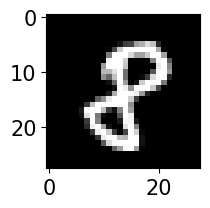

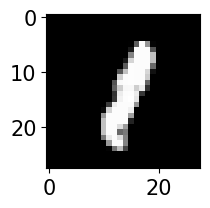

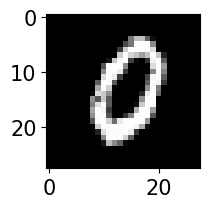

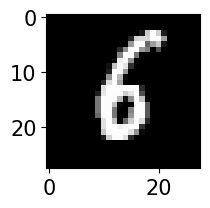

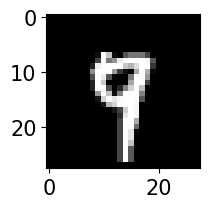

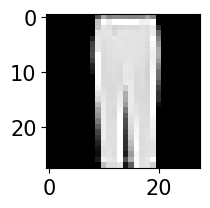

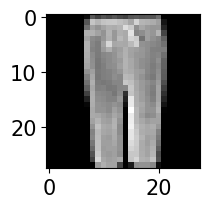

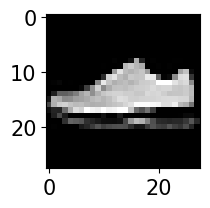

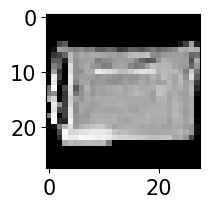

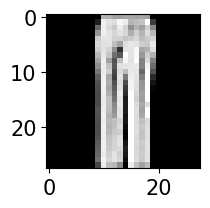

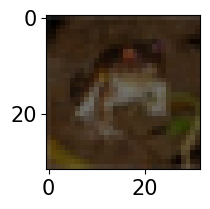

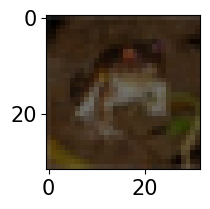

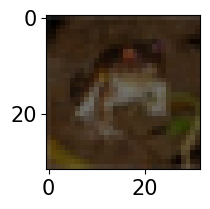

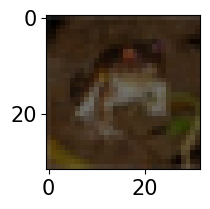

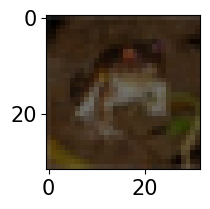

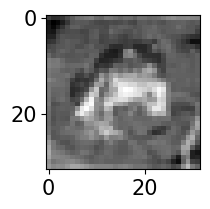

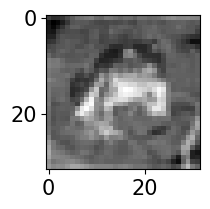

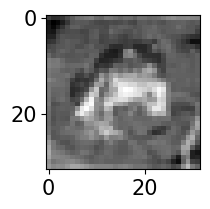

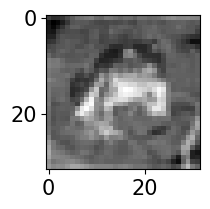

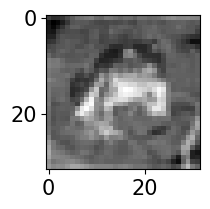

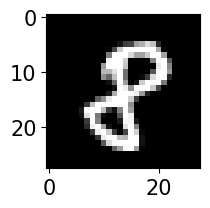

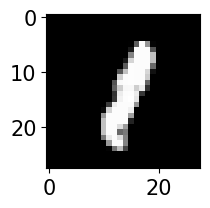

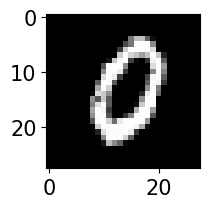

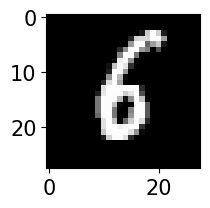

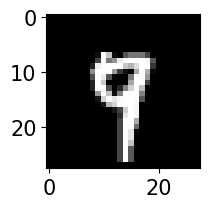

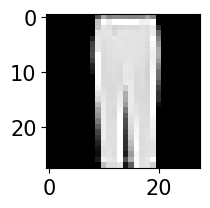

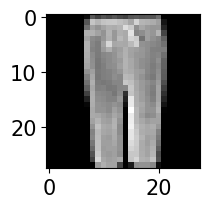

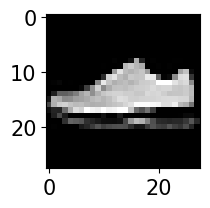

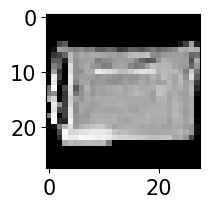

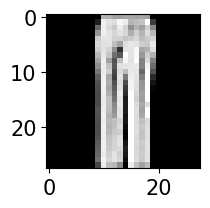

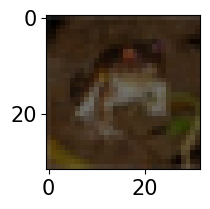

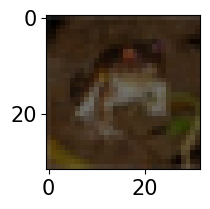

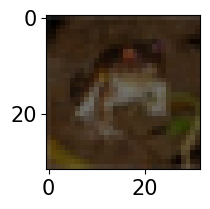

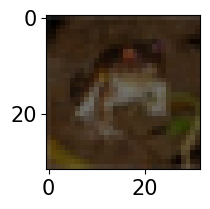

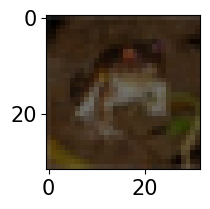

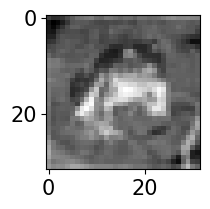

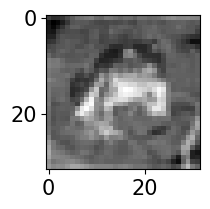

In [7]:
# Two hidden layers. First hidden: Sparse. Second hidden: 0.5

prepend='all_'

numtrials=5

dotheory=False
zeromean=False

mh0=0
mw0=0
mh=0
mw=0


s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']

Ps=np.ceil(np.power(2,np.linspace(7,12,6))).astype(int)
Ns=2*Ps

np.random.seed(0)
for i,P in enumerate(Ps):
    for dataName in dataNames:#dataNames:
        print(dataName)
        for j in range(numtrials):
            print(j)
            seed=j
            N=Ns[i]
            
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            runTrial_last_dense_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,mh0=mh0,mw0=mw0,mh=mh,mw=mw,dotheory=False,
                     s0=0,sep=False,x_test=x_test,y_test=y_test,prepend=prepend,append='_seed'+str(seed))

            

In [11]:
#Circulant experiment

L=3

dotheory=False
zeromean=False
m=0
s0=1.1

dataNames=['MNIST','Fashion','CIFAR','CIFARG']
#dataNames=['CIFAR','CIFARG']

Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
Ns=2*Ps

#mws=[0,4,8,12,16,20]#0,2,4,6]
mws=[0,4,8,12,16,20]#0,2,4,6]
powermin=-3
powermax=np.log(0.4999)/np.log(10)
pas=jnp.power(10,jnp.linspace(powermin,powermax,20))[::-1]


for dataName in ['Circulant']:#dataNames:
    print(dataName)
    for i,P in enumerate(Ps):
        seed=0
        N=Ns[i]
        X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
        #runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)
        runTrial_flat_M(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,L=L,mws=mws,pas=pas,dotheory=dotheory,
                s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend='circ_exp_',append='_seed'+str(seed))
#zeromean=False
#dataName='CIFAR'
#P=Ps[2]
#X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
#runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)


Circulant
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:1.70e-01, sigma:1.41, pa:5.00e-01, mw:0.0, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.09e-01, sigma:0.40, pa:5.00e-01, mw:36.8421052631579, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.74e-01, sigma:0.29, pa:5.00e-01, mw:73.6842105263158, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.88e-01, sigma:0.24, pa:5.00e-01, mw:110.5263157894737, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
done
err:9.93e-01, sigma:0.20, pa:5.00e-01, mw:147.3684210526316, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
done
0th layer kernel save

KeyboardInterrupt: 

dataName
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.90e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:4.23e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:3.93e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:3.76e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:3.66e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:3.61e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:3.57e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:3.55e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:3.54e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:3.54e-02, sigma:1.41, pa:5.00e-01, m:0, 

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.52e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:3.87e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:3.63e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:3.55e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:3.56e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:3.62e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:3.71e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:3.84e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:3.98e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:4.14e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:4.31e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
e

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.17e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:3.63e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:3.60e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:3.80e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:4.16e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:4.64e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:5.20e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:5.80e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:6.39e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:6.90e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:7.29e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:7.55e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:7.71e-02, sigma:3.18, pa:1.90e-01,

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.81e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:3.88e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:4.96e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:6.52e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:7.60e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:7.89e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:7.94e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:7.94e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:7

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.35e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:3.51e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:3.17e-02, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:3.00e-02, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:2.91e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:2.86e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:2.85e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:2.85e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:2.87e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:2.90e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:2.94e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:2.99e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:3.04e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:3.10e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:3

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.90e-02, sigma:2.65, pa:2.42e-01, m:0, L:2, 
err:3.15e-02, sigma:2.65, pa:2.42e-01, m:0, L:3, 
err:2.91e-02, sigma:2.65, pa:2.42e-01, m:0, L:4, 
err:2.86e-02, sigma:2.65, pa:2.42e-01, m:0, L:5, 
err:2.92e-02, sigma:2.65, pa:2.42e-01, m:0, L:6, 
err:3.06e-02, sigma:2.65, pa:2.42e-01, m:0, L:7, 
err:3.27e-02, sigma:2.65, pa:2.42e-01, m:0, L:8, 
err:3.55e-02, sigma:2.65, pa:2.42e-01, m:0, L:9, 
err:3.91e-02, sigma:2.65, pa:2.42e-01, m:0, L:10, 
err:4.33e-02, sigma:2.65, pa:2.42e-01, m:0, L:11, 
err:4.81e-02, sigma:2.65, pa:2.42e-01, m:0, L:12, 
err:5.33e-02, sigma:2.65, pa:2.42e-01, m:0, L:13, 
err:5.84e-02, sigma:2.65, pa:2.42e-01, m:0, L:14, 
err:6.31e-02, sigma:2.65, pa:2.42e-01, m:0, L:15, 
err:6.72e-02, sigma:2.65, pa:2.42e-01, m:0, L:16, 
err:7.06e-02, sigma:2.6

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.45e-02, sigma:5.53, pa:8.74e-02, m:0, L:2, 
err:2.93e-02, sigma:5.53, pa:8.74e-02, m:0, L:3, 
err:3.04e-02, sigma:5.53, pa:8.74e-02, m:0, L:4, 
err:3.57e-02, sigma:5.53, pa:8.74e-02, m:0, L:5, 
err:4.57e-02, sigma:5.53, pa:8.74e-02, m:0, L:6, 
err:5.90e-02, sigma:5.53, pa:8.74e-02, m:0, L:7, 
err:7.00e-02, sigma:5.53, pa:8.74e-02, m:0, L:8, 
err:7.58e-02, sigma:5.53, pa:8.74e-02, m:0, L:9, 
err:7.79e-02, sigma:5.53, pa:8.74e-02, m:0, L:10, 
err:7.86e-02, sigma:5.53, pa:8.74e-02, m:0, L:11, 
err:7.88e-02, sigma:5.53, pa:8.74e-02, m:0, L:12, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:13, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:14, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:15, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:16, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0,

15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.07e-01, sigma:1.57, pa:4.48e-01, m:0, L:2, 
err:9.65e-02, sigma:1.57, pa:4.48e-01, m:0, L:3, 
err:9.06e-02, sigma:1.57, pa:4.48e-01, m:0, L:4, 
err:8.68e-02, sigma:1.57, pa:4.48e-01, m:0, L:5, 
err:8.40e-02, sigma:1.57, pa:4.48e-01, m:0, L:6, 
err:8.19e-02, sigma:1.57, pa:4.48e-01, m:0, L:7, 
err:8.03e-02, sigma:1.57, pa:4.48e-01, m:0, L:8, 
err:7.91e-02, sigma:1.57, pa:4.48e-01, m:0, L:9, 
err:7.80e-02, sigma:1.57, pa:4.48e-01, m:0, L:10, 
err:7.72e-02, sigma:1.57, pa:4.48e-01, m:0, L:11, 
err:7.65e-02, sigma:1.57, pa:4.48e-01, m:0, L:12, 
err:7.59e-02, sigma:1.57, pa:4.48e-01, m:0, L:13, 
err:7.54e-02, sigma:1.57, pa:4.48e-01, m:0, L:14, 
err:7.50e-02, sigma:1.57, pa:4.48e-01, m:0, L:15, 
err:7.47e-02, sigma:1.57, pa:4.48e-01, m:0, L:16, 
err:7.44e-02, sigma:1.57, pa:4.48e-01, m:0, L:17, 
err:7.41e-02, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:7.39e-02, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a

err:7.97e-02, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:7.71e-02, sigma:2.27, pa:2.94e-01, m:0, L:6, 
err:7.53e-02, sigma:2.27, pa:2.94e-01, m:0, L:7, 
err:7.42e-02, sigma:2.27, pa:2.94e-01, m:0, L:8, 
err:7.35e-02, sigma:2.27, pa:2.94e-01, m:0, L:9, 
err:7.31e-02, sigma:2.27, pa:2.94e-01, m:0, L:10, 
err:7.30e-02, sigma:2.27, pa:2.94e-01, m:0, L:11, 
err:7.32e-02, sigma:2.27, pa:2.94e-01, m:0, L:12, 
err:7.35e-02, sigma:2.27, pa:2.94e-01, m:0, L:13, 
err:7.39e-02, sigma:2.27, pa:2.94e-01, m:0, L:14, 
err:7.45e-02, sigma:2.27, pa:2.94e-01, m:0, L:15, 
err:7.51e-02, sigma:2.27, pa:2.94e-01, m:0, L:16, 
err:7.57e-02, sigma:2.27, pa:2.94e-01, m:0, L:17, 
err:7.63e-02, sigma:2.27, pa:2.94e-01, m:0, L:18, 
err:7.68e-02, sigma:2.27, pa:2.94e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kern

err:7.65e-02, sigma:4.01, pa:1.39e-01, m:0, L:9, 
err:7.77e-02, sigma:4.01, pa:1.39e-01, m:0, L:10, 
err:7.84e-02, sigma:4.01, pa:1.39e-01, m:0, L:11, 
err:7.87e-02, sigma:4.01, pa:1.39e-01, m:0, L:12, 
err:7.89e-02, sigma:4.01, pa:1.39e-01, m:0, L:13, 
err:7.89e-02, sigma:4.01, pa:1.39e-01, m:0, L:14, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:15, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:16, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:17, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:18, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

err:7.77e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:7.69e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
err:7.63e-02, sigma:1.41, pa:5.00e-01, m:0, L:13, 
err:7.58e-02, sigma:1.41, pa:5.00e-01, m:0, L:14, 
err:7.53e-02, sigma:1.41, pa:5.00e-01, m:0, L:15, 
err:7.49e-02, sigma:1.41, pa:5.00e-01, m:0, L:16, 
err:7.45e-02, sigma:1.41, pa:5.00e-01, m:0, L:17, 
err:7.42e-02, sigma:1.41, pa:5.00e-01, m:0, L:18, 
err:7.39e-02, sigma:1.41, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.13e-01, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:9.86e-02, sigma:1.49, pa:4.74e-01, m:0, L

err:7.10e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:7.10e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:7.11e-02, sigma:1.99, pa:3.45e-01, m:0, L:15, 
err:7.12e-02, sigma:1.99, pa:3.45e-01, m:0, L:16, 
err:7.14e-02, sigma:1.99, pa:3.45e-01, m:0, L:17, 
err:7.17e-02, sigma:1.99, pa:3.45e-01, m:0, L:18, 
err:7.20e-02, sigma:1.99, pa:3.45e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.06e-01, sigma:2.12, pa:3.19e-01, m:0, L:2, 
err:9.10e-02, sigma:2.12, pa:3.19e-01, m:0, L:3, 
err:8.34e-02, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:7.89e-02, sigma:2.12, pa:3.19e-01, m:0, L:5

err:7.81e-02, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:7.85e-02, sigma:3.18, pa:1.90e-01, m:0, L:16, 
err:7.87e-02, sigma:3.18, pa:1.90e-01, m:0, L:17, 
err:7.88e-02, sigma:3.18, pa:1.90e-01, m:0, L:18, 
err:7.89e-02, sigma:3.18, pa:1.90e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.90e-02, sigma:3.55, pa:1.65e-01, m:0, L:2, 
err:8.36e-02, sigma:3.55, pa:1.65e-01, m:0, L:3, 
err:7.64e-02, sigma:3.55, pa:1.65e-01, m:0, L:4, 
err:7.29e-02, sigma:3.55, pa:1.65e-01, m:0, L:5, 
err:7.13e-02, sigma:3.55, pa:1.65e-01, m:0, L:6, 
err:7.11e-02, sigma:3.55, pa:1.65e-01, m:0, L:7, 

err:7.90e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:7.90e-02, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:7.90e-02, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.64e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:7.30e-02, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:7.30e-02, sigma:21.74, pa:1.00e-02, m:0, L:4, 
err:7.79e-02, sigma:21.74, pa:1.00e-02, m:0, L:5, 
err:7.96e-02, sigma:21.74, pa:1.00e-02, m:0, L:6, 
err:7.97e-02, sigma:21.74, pa:1.00e-02, m:0, L:7, 
err:7.98e-02, sigma:21.74, pa:1.00e-02, m:0, L:8, 
err:7.98e-02, sigma:21.74, pa:1.00e-02, m:0,

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.16e-01, sigma:1.87, pa:3.71e-01, m:0, L:2, 
err:1.03e-01, sigma:1.87, pa:3.71e-01, m:0, L:3, 
err:9.52e-02, sigma:1.87, pa:3.71e-01, m:0, L:4, 
err:9.00e-02, sigma:1.87, pa:3.71e-01, m:0, L:5, 
err:8.64e-02, sigma:1.87, pa:3.71e-01, m:0, L:6, 
err:8.37e-02, sigma:1.87, pa:3.71e-01, m:0, L:7, 
err:8.16e-02, sigma:1.87, pa:3.71e-01, m:0, L:8, 
err:8.01e-02, sigma:1.87, pa:3.71e-01, m:0, L:9, 
err:7.88e-02, sigma:1.87, pa:3.71e-01, m:0, L:10, 
err:7.79e-02, sigma:1.87, pa:3.71e-01, m:0, L:11, 
err:7.71e-02, sigma:1.87, pa:3.71e-01, m:0, L:12, 
e

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.10e-01, sigma:2.89, pa:2.16e-01, m:0, L:2, 
err:9.53e-02, sigma:2.89, pa:2.16e-01, m:0, L:3, 
err:8.68e-02, sigma:2.89, pa:2.16e-01, m:0, L:4, 
err:8.17e-02, sigma:2.89, pa:2.16e-01, m:0, L:5, 
err:7.85e-02, sigma:2.89, pa:2.16e-01, m:0, L:6, 
err:7.67e-02, sigma:2.89, pa:2.16e-01, m:0, L:7, 
err:7.57e-02, sigma:2.89, pa:2.16e-01, m:0, L:8, 
err:7.53e-02, sigma:2.89, pa:2.16e-01, m:0, L:9, 
err:7.54e-02, sigma:2.89, pa:2.16e-01, m:0, L:10, 
err:7.58e-02, sigma:2.89, pa:2.16e-01, m:0, L:11, 
err:7.64e-02, sigma:2.89, pa:2.16e-01, m:0, L:12, 
err:7.71e-02, sigma:2.89, pa:2.16e-01, m:0, L:13, 
err:7.77e-02, sigma:2.89, pa:2.16e-01,

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.02e-01, sigma:6.98, pa:6.16e-02, m:0, L:2, 
err:8.53e-02, sigma:6.98, pa:6.16e-02, m:0, L:3, 
err:7.80e-02, sigma:6.98, pa:6.16e-02, m:0, L:4, 
err:7.57e-02, sigma:6.98, pa:6.16e-02, m:0, L:5, 
err:7.63e-02, sigma:6.98, pa:6.16e-02, m:0, L:6, 
err:7.79e-02, sigma:6.98, pa:6.16e-02, m:0, L:7, 
err:7.88e-02, sigma:6.98, pa:6.16e-02, m:0, L:8, 
err:7.90e-02, sigma:6.98, pa:6.16e-02, m:0, L:9, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:10, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:11, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:13, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:14, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:15, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:16, 


10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.29e-01, sigma:1.66, pa:4.23e-01, m:0, L:2, 
err:1.09e-01, sigma:1.66, pa:4.23e-01, m:0, L:3, 
err:9.95e-02, sigma:1.66, pa:4.23e-01, m:0, L:4, 
err:9.35e-02, sigma:1.66, pa:4.23e-01, m:0, L:5, 
err:8.93e-02, sigma:1.66, pa:4.23e-01, m:0, L:6, 
err:8.63e-02, sigma:1.66, pa:4.23e-01, m:0, L:7, 
err:8.40e-02, sigma:1.66, pa:4.23e-01, m:0, L:8, 
err:8.22e-02, sigma:1.66, pa:4.23e-01, m:0, L:9, 
err:8.07e-02, sigma:1.66, pa:4.23e-01, m:0, L:10, 
err:7.96e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:7.86e-02, sigma:1.66, pa:4.23e-01, m:0, L:12, 
err:7.78e-02, sigma:1.66, pa:4.23e-01, m:0, L:13, 
err:7.72e-02, sigma:1.66, pa:4.23e-01, m:0, L:14, 
err:7.66e-02, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:7.61e-02, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:7.57e-02, sigma:1.66, pa:4.23e-01, m:0, L:

13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.20e-01, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:9.99e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:8.99e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:8.40e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:8.02e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:7.77e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:7.60e-02, sigma:2.45, pa:2.68e-01, m:0, L:8, 
err:7.49e-02, sigma:2.45, pa:2.68e-01, m:0, L:9, 
err:7.43e-02, sigma:2.45, pa:2.68e-01, m:0, L:10, 
err:7.40e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:7.39e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:7.41e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:7.43e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:7.47e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:7.51e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:7.56e-02, sigma:2.45, pa:2.68e-01, m:0, L:17, 
err:7.62e-02, sigma:2.45, pa:2.68e-01, m:0, L:18, 
err:7.67e-02, si

16th layer kernel saved
17th layer kernel saved
done
err:1.10e-01, sigma:4.63, pa:1.13e-01, m:0, L:2, 
err:8.99e-02, sigma:4.63, pa:1.13e-01, m:0, L:3, 
err:8.06e-02, sigma:4.63, pa:1.13e-01, m:0, L:4, 
err:7.61e-02, sigma:4.63, pa:1.13e-01, m:0, L:5, 
err:7.43e-02, sigma:4.63, pa:1.13e-01, m:0, L:6, 
err:7.41e-02, sigma:4.63, pa:1.13e-01, m:0, L:7, 
err:7.50e-02, sigma:4.63, pa:1.13e-01, m:0, L:8, 
err:7.63e-02, sigma:4.63, pa:1.13e-01, m:0, L:9, 
err:7.76e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:7.84e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:7.87e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:7.89e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:7.89e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:15, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:16, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

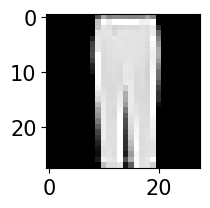

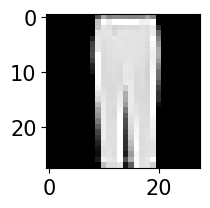

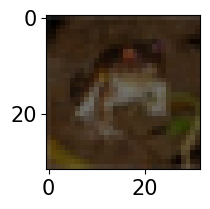

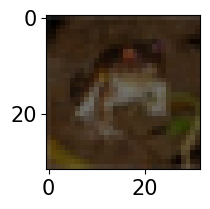

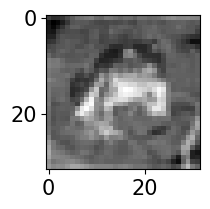

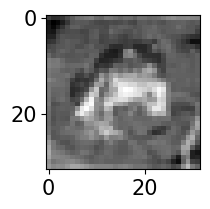

In [64]:
dotheory=True
m=0
s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']

#Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
#Ns=2*Ps
#Ps=np.power(2,np.linspace(4,12,6)).astype(int)
#Ns=5*Ps
Ps=np.power(2,np.linspace(7,10,3)).astype(int)
Ns=Ps*10

for dataName in dataNames[1:]:
    print('dataName')
    #for i,P in enumerate(Ps[4:6]):
    for i,P in enumerate(Ps[:-1]):
        N=Ns[i]
        #N=6*P
        seed=0
        X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)  
        runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)
        

In [15]:
Y

DeviceArray([[ 0.9, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
             [ 0.9, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
             [ 0.9, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
             ...,
             [-0.1, -0.1, -0.1, ..., -0.1, -0.1,  0.9],
             [-0.1, -0.1, -0.1, ..., -0.1, -0.1,  0.9],
             [-0.1, -0.1, -0.1, ..., -0.1, -0.1,  0.9]], dtype=float32)

In [29]:
def runTrialAC(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,x_test,m=0,dotheory=False,s0=0):
    resolution=100000000#100000000
    trapz_n=10000
    chunk_size=100000

    Ls=jnp.arange(2,20)
    #pas=[0.4999,0.2,0.1]
    pas=jnp.linspace(0.4999,0.01,20)
    taus=gp.getTau(jnp.array(pas))

    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        sigma=np.squeeze(gp.getosig(tau))
        converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)

        if dotheory:
            load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        else:
            load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getSCK_fast_and_save(x_train,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
            #load_names_te=gp.getSCK_fast_and_save(x_train,x_test,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')

        for g, L in enumerate(Ls):
        #try:
            if dotheory:
                K=np.load(load_names_te[g])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]
            else:
                K=0
                A=np.load(load_names_tr[g])
                C=np.load(load_names_te[g])
            
            K=K/jnp.max(A)
            C=C/jnp.max(A)
            A=A/jnp.max(A)
            

            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)
            
            
            errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
            accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, m:{}, L:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),m,L))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)
                
                vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)
                
                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)
                
                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'

    filename='AC_'+'withacc_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0)
    np.savez('./sweep_data/'+filename,P=P,N=N,m=m,s0=s0,Ls=Ls,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams)



loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.96e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:5.97e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:5.47e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:5.16e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:4.94e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:4.78e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:4.66e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:4.56e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:4.48e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:4.42e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:4.36e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
e

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.48e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:5.44e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:4.91e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:4.59e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:4.37e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:4.22e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:4.12e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:4.05e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:4.00e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:3.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:3.95e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:3.94e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:3.94e-02, s

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.01e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:4.93e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:4.41e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:4.13e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:3.99e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:3.94e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:3.95e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:4.00e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:4.06e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:4.14e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:4.23e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:4.31e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:4.38e-02, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:4.43e-02, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:4

11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.33e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:4.26e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:3.97e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:4.06e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:4.29e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:4.45e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:4.51e-02, sigma

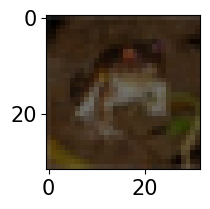

In [30]:
dotheory=True
m=0
s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']


Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
Ns=2*Ps

dataName='CIFAR'
#P=Ps[3]
P=600
N=1200
seed=0
X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)  
runTrialAC(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,x_test,m=m,dotheory=dotheory,s0=s0)
        

In [ ]:
## Comparison to the google brain result

dotheory=False
zeromean=False
m=0
s0=0

dataNames=['MNIST','CIFAR']
#dataNames=['CIFAR','CIFARG']

Ps=np.array([100,200,500,1000,2000,5000,10000])

seeds=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for seed in seeds:
    for dataName in dataNames:
        print(dataName)
        for i,P in enumerate(Ps):
            #seed=0
            N=int(10000+P)
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=0,dotheory=False,
                     s0=0,sep=True,x_test=x_test,y_test=y_test,append='_seed'+str(seed))



MNIST
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.96e-02, sigma:1.41, pa:5.00e-01

done
err:4.71e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:4.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:4.23e-02, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:4.25e-02, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:4.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:4.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:4.56e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:4.72e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:4.88e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:5.06e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:5.24e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:5.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:5.62e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:5.81e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:6.01e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:6.20e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:6.39e-02, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:6.57e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel sav

7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:4.18e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:4.28e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:4.56e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:4.96e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:5.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:5.9

err:9.04e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:9.05e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:9.05e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:9.06e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:9.06e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:9.06e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel 

15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.10e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:5.36e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:7.65e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:8.81e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:9.07e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:9.11e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:9.11e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a

err:4.34e-02, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:4.43e-02, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.01e-02, sigma:1.66,

err:3.45e-02, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:3.55e-02, sigma:2.12, pa:3.19e-01, m:0, L:5, 
err:3.73e-02, sigma:2.12, pa:3.19e-01, m:0, L:6, 
err:3.96e-02, sigma:2.12, pa:3.19e-01, m:0, L:7, 
err:4.24e-02, sigma:2.12, pa:3.19e-01, m:0, L:8, 
err:4.56e-02, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:4.90e-02, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:5.28e-02, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:5.66e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:6.05e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:6.44e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:6.80e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:7.14e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:7.45e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:7.73e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:7.97e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer 

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.54e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:3.40e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:3.68e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:4.23e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:4.99e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:5.88e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:6.77e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:7.54e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:8.12e-02, sigma:3.18

err:9.05e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:9.05e-02, sigma:5.53, pa:8.74e-02, m:0, L:18, 
err:9.05e-02, sigma:5.53, pa:8.74e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.01e-02, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:2.74e-02, sigma:1.49, pa:4.74e-01, m:0, L:3, 
err:2.66e-02, sigma:1.49, pa:4.74e-01, m:0, L:4, 
err:2.63e-02, sigma:1.49, pa:4.74e-01, m:0, L:5, 
err:2.63e-02, sigma:1.49, pa:4.74e-01, m:0, L:6, 
err:2.65e-02, sigma:1.49, pa:4.74e-01, m:0, L:7, 
err:2.67e-02, sigma:1.49, pa:4.74e-01, m:0, L:8, 
err:2.70e-02, sigma:1.49, pa:4.74e-01, m:0, L:9, 
err:2.73e-02, sigma:1.49, pa:4.74e-01, m:0, L:10, 
err:2.76e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:2.79e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:2.83e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:2.87e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:2.90e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:2.94e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:2.98e-02, sigma:1.4

In [35]:
Ns

array([  200,   504,  1262,  3170,  7964, 20000])

MNIST
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.12e-02, sigma:1.41, pa:5.00e-01

16th layer kernel saved
17th layer kernel saved
done
err:1.08e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:9.93e-03, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:9.77e-03, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:9.85e-03, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:1.00e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:1.03e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:1.06e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:1.10e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:1.14e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:1.18e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:1.22e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:1.27e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:1.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:1.37e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:1.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:1.49e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:1.55e-02, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:1.62e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.03e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:9.64e-03, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:9.85e-03, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:1.04e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:1.13e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:1.25e-02, sigma:2.45, pa:2.68e

err:4.26e-02, sigma:3.55, pa:1.65e-01, m:0, L:12, 
err:4.38e-02, sigma:3.55, pa:1.65e-01, m:0, L:13, 
err:4.45e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:4.48e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:4.49e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:4.50e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:4.50e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:4.51e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th laye

10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.41e-03, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:1.18e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:2.07e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:3.53e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:4.31e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:4.47e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:4.52e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:4.54e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:4.55e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:

err:1.36e-02, sigma:1.57, pa:4.48e-01, m:0, L:17, 
err:1.39e-02, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:1.43e-02, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

err:9.91e-03, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:1.02e-02, sigma:2.12, pa:3.19e-01, m:0, L:5, 
err:1.07e-02, sigma:2.12, pa:3.19e-01, m:0, L:6, 
err:1.14e-02, sigma:2.12, pa:3.19e-01, m:0, L:7, 
err:1.21e-02, sigma:2.12, pa:3.19e-01, m:0, L:8, 
err:1.31e-02, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:1.41e-02, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:1.53e-02, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:1.66e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:1.81e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:1.98e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:2.16e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:2.35e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:2.55e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:2.76e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:2.97e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer 

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.00e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:9.64e-03, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:1.04e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:1.18e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:1.40e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:1.71e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:2.11e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:2.58e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:3.09e-02, sigma:3.18

err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:18, 
err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.84e-02, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:3.88e-02, sigma:1.49, pa:4.74e-01, m:0, L:3, 
err:4.04e-02, sigma:1.49, pa:4.74e-01, m:0, L:4, 
err:4.24e-02, sigma:1.49, pa:4.74e-01, m:0, L:5, 
err:4.45e-02, sigma:1.49, pa:4.74e-01, m:0, L:6, 
err:4.68e-02, sigma:1.49, pa:4.74e-01, m:0, L:7, 
err:4.91e-02, sigma:1.49, pa:4.74e-01, m:0, L:8, 
err:5.14e-02, sigma:1.49, pa:4.74e-01, m:0, L:9, 
err:5.36e-02, sigma:1.49, pa:4.74e-01, m:0, L:10, 
err:5.57e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:5.77e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:5.97e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:6.15e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:6.32e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:6.49e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:6.64e-02, sigma:1.49, pa:4.74e-01, m:0, L:

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.08e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:2.90e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:2.88e-02, sigma:1.99, pa:3.45e-01, m:0, L:

err:3.45e-02, sigma:2.65, pa:2.42e-01, m:0, L:9, 
err:3.92e-02, sigma:2.65, pa:2.42e-01, m:0, L:10, 
err:4.40e-02, sigma:2.65, pa:2.42e-01, m:0, L:11, 
err:4.85e-02, sigma:2.65, pa:2.42e-01, m:0, L:12, 
err:5.22e-02, sigma:2.65, pa:2.42e-01, m:0, L:13, 
err:5.52e-02, sigma:2.65, pa:2.42e-01, m:0, L:14, 
err:5.74e-02, sigma:2.65, pa:2.42e-01, m:0, L:15, 
err:5.89e-02, sigma:2.65, pa:2.42e-01, m:0, L:16, 
err:6.00e-02, sigma:2.65, pa:2.42e-01, m:0, L:17, 
err:6.07e-02, sigma:2.65, pa:2.42e-01, m:0, L:18, 
err:6.12e-02, sigma:2.65, pa:2.42e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.43e-02, sigma:4.63, pa:1.13e-01, m:0, L:2, 
err:1.29e-02, sigma:4.63, pa:1.13e-01, m:0, L:3, 
err:1.48e-02, sigma:4.63, pa:1.13e-01, m:0, L:4, 
err:1.96e-02, sigma:4.63, pa:1.13e-01, m:0, L:5, 
err:2.72e-02, sigma:4.63, pa:1.13e-01, m:0, L:6, 
err:3.60e-02, sigma:4.63, pa:1.13e-01, m:0, L:7, 
err:4.27e-02, sigma:4.63, pa:1.13e-01, m:0, L:8, 
err:4.63e-02, sigma:4.63, pa:1.13e-01, m:0, L:9, 
err:4.78e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:4.84e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:4.87e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:4.88e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:4.89e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:4.90e-

err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:18, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:19, 
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kerne

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.45e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:8.57e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:8.65e-02, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:8.72e-02, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:8.78e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:8.82e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:8.86e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:8.88e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:8.91e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:8.93e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:8.94e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:8.96e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:8.97e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:8.98e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:8.99e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:9.00e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:9.00e-02, sigma:1.76, pa:3.97e-01, m:0,

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.82e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:8.01e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:8.20e-02, sigma:2.45, pa:2.68e-01, m:0, L:

err:8.94e-02, sigma:3.55, pa:1.65e-01, m:0, L:11, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:12, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:13, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.79e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:4.76e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:6.80e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:7.87e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:8.10e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:8.13e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.85e-02, sigma:1.66, pa:4.23e-01, m:0, L:2, 
err:5.18e-02, sigma:1.66, pa:4.23e-01, m:0, L:3, 
err:4.81e-02, sigma:1.66, pa:4.23e-01, m:0, L:

err:3.88e-02, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:3.84e-02, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:3.83e-02, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:3.82e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:3.83e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:3.84e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:3.86e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:3.89e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:3.92e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:3.95e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:3.98e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.61e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:4.70e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:4.24e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:4.00e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:3.87e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:3.83e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:3.84e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:3.89e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:3.96e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:4.05e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:4.14e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:4.23e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:4.31e-02, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:4.38e-

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.23e-02, sigma:6.98, pa:6.16e-02, m:0, L:2, 
err:4.26e-02, sigma:6.98, pa:6.16e-02, m:0, L:3, 
err:3.90e-02, sigma:6.98, p

err:5.95e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:5.95e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:5.96e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:5.97e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:5.99e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:6.00e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:6.02e-02, sigma:1.49, pa:4.74e-01, m:0, L:17, 
err:6.04e-02, sigma:1.49, pa:4.74e-01, m:0, L:18, 
err:6.06e-02, sigma:1.49, pa:4.74e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.94e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:5.40e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:5.02e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:4.73e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:4.51e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:4.35e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:4.22e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:4.13e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:4.07e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:4.02e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:3.99e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:3.98e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:3.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:3.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:15, 
err:3.98e-02, sigma:1.99, pa:3.45e-01, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.27e-02, sigma:2.89, pa:2.16e-01, m:0, L:2, 
err:4.62e-02, sigma:2.89, pa:2.16e-01, m:0, L:3, 
err:4.26e-02, sigma:2.89, pa:2.16e-01, m:0, L:

err:4.34e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:4.43e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:4.47e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:4.49e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:4.50e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:4.51e-02, sigma:4.63, pa:1.13e-01, m:0, L:15, 
err:4.54e-02, sigma:4.63, pa:1.13e-01, m:0, L:16, 
err:4.61e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:4.75e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:4.94e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel save

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.47e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:8.50e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:8.53e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:8.57e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:8.60e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:8.63e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:8.66e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:8.69e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:8.71e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:8.73e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:8.75e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
err:8.77e-02, sigma:1.41, pa:5.00e-01, m:0, L:13, 
err:8.79e-02, sigma:1.41, pa:5.00e-01, m:0, L:14, 
err:8.81e-

err:8.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.25e-02, sigma:1.87, pa:3.71e-01, m:0, L:2, 
err:8.21e-02, sigma:1.87, 

err:7.52e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:7.57e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:7.64e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:7.71e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:7.78e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:7.84e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:7.89e-02, sigma:2.45, pa:2.68e-01, m:0, L:17, 
err:7.93e-02, sigma:2.45, pa:2.68e-01, m:0, L:18, 
err:7.97e-02, sigma:2.45, pa:2.68e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.47e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:7.01e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:6.57e-02, sigma:4.01, pa:1.39e-01, m:0, L:4, 
err:6.23e-02, sigma:4.01, pa:1.39e-01, m:0, L:5, 
err:6.06e-02, sigma:4.01, pa:1.39e-01, m:0, L:6, 
err:6.04e-02, sigma:4.01, pa:1.39e-01, m:0, L:7, 
err:6.13e-02, sigma:4.01, pa:1.39e-01, m:0, L:8, 
err:6.27e-02, sigma:4.01, pa:1.39e-01, m:0, L:9, 
err:6.41e-02, sigma:4.01, pa:1.39e-01, m:0, L:10, 
err:6.51e-02, sigma:4.01, pa:1.39e-01, m:0, L:11, 
err:6.57e-02, sigma:4.01, pa:1.39e-01, m:0, L:12, 
err:6.60e-02, sigma:4.01, pa:1.39e-01, m:0, L:13, 
err:6.61e-02, sigma:4.01, pa:1.39e-01, m:0, L:14, 
err:6.62e-02, sigma:4.01, pa:1.39e-01, m:0, L:15, 
err:6.62e-02, sigma:4.01, pa:1.39e-01, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.66e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:3.95e-02, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:3.98e-02, sigma:21.74, pa:1.00e-02, m:0,

err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:12, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:13, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:14, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:17, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:18, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.15e-02, sigma:2.27, pa:2.94e-01, m:0, L:2, 
err:9.16e-02, sigma:2.27, pa:2.94e-01, m:0, L:3, 
err:9.17e-02, sigma:2.27, pa:2.94e-01, m:0, L:4, 
err:9.18e-02, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:9.20e-02, sigma:2.27, pa:2.94e-01, m:0, L:6, 
err:9.21e-02, sigma:2.27, pa:2.94e-01, m:0, L:7, 
err:9.23e-02, sigma:2.27, pa:2.94e-01, m:0, L:8, 
err:9.25e-02, sigma:2.27, pa:2.94e-01, m:0, L:9, 
err:9.26e-02, sigma:2.27, pa:2.94e-01, m:0, L:10, 
err:9.28e-02, sigma:2.27, pa:2.94e-01, m:0, L:11, 
err:9.29e-02, sigma:2.27, pa:2.94e-01, m:0, L:12, 
err:9.30e-02, sigma:2.27, pa:2.94e-01, m:0, L:13, 
err:9.31e-02, sigma:2.27, pa:2.94e-01, m:0, L:14, 
err:9.31e-02, sigma:2.27, pa:2.94e-01, m:0, L:15, 
err:9.32e-02, sigma:2.27, pa:2.94e-01, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:2, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:3, 
err:8.98e-02, sigma:3.55, pa:1.65e-01, m:0, L:

err:9.21e-02, sigma:6.98, pa:6.16e-02, m:0, L:8, 
err:9.21e-02, sigma:6.98, pa:6.16e-02, m:0, L:9, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:10, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:11, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:13, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:14, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:15, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:16, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:17, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:18, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

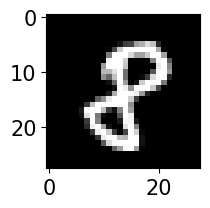

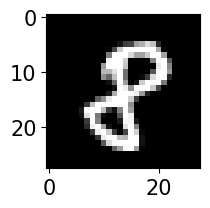

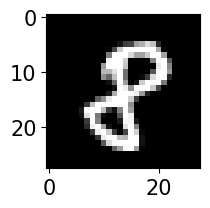

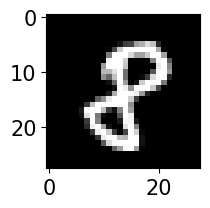

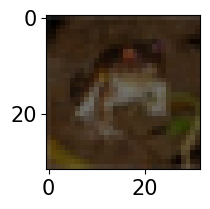

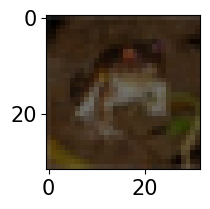

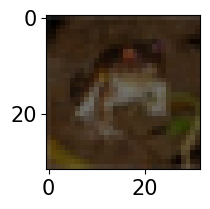

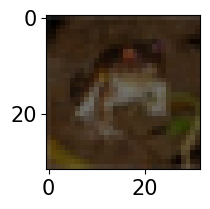

In [6]:
#Appendix: effect of lambda



dotheory=False
zeromean=False
m=0
s0s=np.power(10,np.linspace(-6,0,4))

dataNames=['MNIST','CIFAR']

P=1000
N=2*P

np.random.seed(0)
for dataName in dataNames:#dataNames:
    print(dataName)
    for s0 in s0s:
        seed=0
        X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
        runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=0,dotheory=False,
                 s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend='lamb_comp_',append='_seed'+str(seed))
#zeromean=False
#dataName='CIFAR'
#P=Ps[2]
#X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
#runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)


In [40]:
Ps=np.ceil(np.power(10,np.linspace(1,3.4,6))).astype(int)

print(Ps*6)


[   60   186   552  1656  4992 15072]


In [52]:
Ps=np.power(2,np.linspace(4,11,6)).astype(int)
print(Ps)
print(Ps*5)


[  16   42  111  294  776 2048]
[   80   210   555  1470  3880 10240]


In [63]:
Ps=np.power(2,np.linspace(7.5,10,3)).astype(int)
print(Ps)
print(Ps*10)


[ 181  430 1024]
[ 1810  4300 10240]


In [4]:
Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)



In [5]:
Ps

array([  100,   252,   631,  1585,  3982, 10000])

In [2]:
import numpy as np

np.linspace(0,[2,3],10)

array([[0.        , 0.        ],
       [0.22222222, 0.33333333],
       [0.44444444, 0.66666667],
       [0.66666667, 1.        ],
       [0.88888889, 1.33333333],
       [1.11111111, 1.66666667],
       [1.33333333, 2.        ],
       [1.55555556, 2.33333333],
       [1.77777778, 2.66666667],
       [2.        , 3.        ]])

In [13]:
s=11
n=100
rr=np.linspace(2,12,s)
zetar=np.linspace(10,20,s)

r=rr[:,None]
#zetar[:,None,None]
phi=np.linspace(1e-8,zetar,n).T
L_term=np.exp(-1/(2*np.square(r)*np.square(np.sin(phi))))
inte=(1/np.pi)*np.trapz(L_term,x=phi,axis=-1)


In [14]:
np.shape(phi)

(11, 100)

In [15]:
phi

array([[1.00000000e-08, 1.01010111e-01, 2.02020212e-01, ...,
        9.79797980e+00, 9.89898990e+00, 1.00000000e+01],
       [1.00000000e-08, 1.11111121e-01, 2.22222232e-01, ...,
        1.07777778e+01, 1.08888889e+01, 1.10000000e+01],
       [1.00000000e-08, 1.21212131e-01, 2.42424252e-01, ...,
        1.17575758e+01, 1.18787879e+01, 1.20000000e+01],
       ...,
       [1.00000000e-08, 1.81818192e-01, 3.63636373e-01, ...,
        1.76363636e+01, 1.78181818e+01, 1.80000000e+01],
       [1.00000000e-08, 1.91919202e-01, 3.83838394e-01, ...,
        1.86161616e+01, 1.88080808e+01, 1.90000000e+01],
       [1.00000000e-08, 2.02020212e-01, 4.04040414e-01, ...,
        1.95959596e+01, 1.97979798e+01, 2.00000000e+01]])

chopped
Progress=90.00%, #chunks:10

In [23]:
print(tau)


2.3263483


In [ ]:
gp.getTau(jnp.array(pas))